# Introduction

In this notebook, we will look at trajectory inference using Diffusion Maps, Palantir and PAGA.

# Load packages

In [88]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Trajectory Inference

scRNA-seq has been applied extensively to study developmental systems. The process of differentiation is a continuous process rather than a series of discreet/distinct stages. Trajectory inference is a computational framework to align the cells developing from one phenotype to another along a continuous axis (also called pseudotime).

Underlying pseudotime analysis is the assumption that because differentiation process is asynchronous, a single snapshot of scRNA-seq data comprises of cells in all possible states during the process. This allows us to utilize the heterogeneity among the cells to align them along a continuous axis. In essence, we are interested in capturing gradual changes during the process, which means we ought to understand and map local similarity between cells. And graphs are the perfect mathematical tools to do so. Therefore, all the methods we discuss below will rely on modeling the data using a graph.

There are tens of algorithms developed to perform pseudotime analysis on single-cell RNA-seq data. Here, we will discuss two important methods, namely diffusion maps and Palantir, for their effectiveness and success we have seen in scRNA-seq data analysis. 

Refs: 

https://www.nature.com/articles/s41587-019-0071-9?platform=hootsuite

https://pubmed.ncbi.nlm.nih.gov/30899105/

https://www.nature.com/articles/nmeth.3971

## Diffusion Maps

Diffusion Maps are a suite of graph-based techniques to perform non-linear dimensionality reduction of high-dimensional data. They can be crudely thought of as non-linear version of PCA: just like PCA, diffusion maps will identify axis of high variances in the data, but unlike PCA - which is linear - diffusion maps take into consideration  non-linear associations between features (genes in our case) of the data. In other words, diffusion maps transform any high-dimensional data into a lower dimensional Euclidean space by accounting for any non-linear dependencies between the features. In doing so, it preserves the relationship between points that are similar in high-dimensional space and discards distant relationships. 

This property of diffusion maps makes it very favorable for single-cell data analysis. By preserving the local neighborhood structure, it provides a platform to incrementally navigate along the data manifold. Unlike diffusion maps, UMAP (and Force Directed Layout) - while useful to visualize data - does not accurately preserve high-dimensional pairwise distances in the resulting low-dimensional representation. This limits the use of UMAP (and Force Directed Layout) to visualization and does not facilitate any further quantitative analysis. However, since diffusion maps are distance preserving, they can be used for downstream analysis.

The need for using diffusion maps also stems from our assumption that scRNA-seq data are inherently noisy and biological signals are masked by the noise. As such, we typically begin by performing principal component analysis as a way to decouple strong variability in the data (true biological signal) from random noise by retrieving only the top `p` principal components and neglecting the rest (which typically identify with noise in the data) for any downstream analysis. However, we have observed with scRNA-seq data that PCA is generally ideal for working with global aspects of the data (such as to cluster the cells on, visualize the data etc.) but is not _always_ optimal for a finer analysis such as pseudotime alignment of individual cells. 

One of the popular ways to study cells along a continuum of gene expression space (as opposed to distinct clusters) is to apply diffusion maps on the retrieved principal components. Because the resulting embedding aims to preserve the local neighborhood of each cell, the diffusion maps form a natural coordinate system for cells along a continuum. As a result, they have been most successfully employed to align cells undergoing development along a trajectory. The success of diffusion maps relies on its ability to capture the geometry of the data accurately. 

Diffusion maps work by first building a k-nearest neighbor graph on the principal components (similar to clustering analysis), followed by conversion of the distance graph to an affinity graph. The typically used Gaussian kernel ensures that affinity between cells decrease exponentially with distance between cells in every direction (of PCA space) but remains sensitive to density of cells near every cell. In other words, if the neighborhood of a cell is densely sampled then the similarity between cells is more concentrated while if the neighborhood of a cell is sparsely sampled then the similarity is more diffuse. This is important to avoid bias in analysis due to sampling differences in a heterogeneous population of cells. The affinity matrix is then converted into a Markov matrix, which represents a probabilistic framework of cellular state neighborhood. To elaborate, for a data of K cells, the Markov matrix is of size K-by-K; each row of the matrix sums to 1 and the (i, j)-th entry of the matrix represents the probability of a cell transitioning from state i to state j in one time step. Therefore, the Markov matrix automatically provides a probabilistic representation of cellular transition and is well-suited for pseudotime analysis that aims to align the cells along their differentiation transition states. Furthermore, because we begin with the k-nearest neighbor graph, only the immediate neighborhood each cell (i.e. phenotypically most similar cells) get high probability score of transition. Once the Markov matrix is constructed, we obtain the eigenvalues and eigenvectors of the matrix (analogous to the procedure in PCA) and order the eigenvectors based on the associated eigenvalue. We interpret the top eigenvector (we ignore the first eigenvector with eigenvalue of 1, see references below for this) as the direction of highest variability in the data, and often can be used to study cellular transitions in the data. These eigenvectors are called the diffusion components or diffusion maps. Similarly, we encourage you to explore the next few eigenvectors to study any potential axes of continuum in the data. We will discuss more below. 

Refs: 
https://www.nature.com/articles/nmeth.3971

https://www.nature.com/articles/nbt.3569

https://www.sciencedirect.com/science/article/pii/S1063520306000546

The size of the nearest neighborhood (`k` or `n_neighbors` parameter) is a crucial parameter and analogous to clustering analysis, we recommend you to choose it such that it is small enough to only consider local neighbors of each cell, but large enough that you do not get discrete sub-graphs. Furthermore, it is highly recommended that you show your results do not vary with slight alterations in the value of `n_neighbors`. For example, if you wish to choose `n_neighbors = 30` then we recommend that you recompute the graph for various values of `n_neighbors` around `30` such as `n_neighbors = (21, 24, 27, 30, 33, 36, 39)` and show that the meaningful diffusion components you obtain for all these values of `n_neighbors` are highly correlated to each other. 

## Load data

The data is taken from https://www.nature.com/articles/s41587-019-0068-4 and downloaded from https://github.com/dpeerlab/Palantir. The data has already been normalized, clustered, cell type annotated and visualization maps have also been computed.

The data consists of CD34+ human bone marrow cells undergoing differentiation.

In [90]:
data_path = Path("./data_day1")

In [91]:
# downloaded from https://drive.google.com/drive/u/1/folders/1fXhGtF4qnaiXDBBHvQGfgxDWc9h45oR5

adata_bm = sc.read_h5ad(data_path / "human_cd34_bm_rep1.h5ad")

In [92]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs'

In [93]:
# Change the name of the obsm so we can invoke scanpy plotting functions
adata_bm.obsm["X_tsne"] = adata_bm.obsm["tsne"]

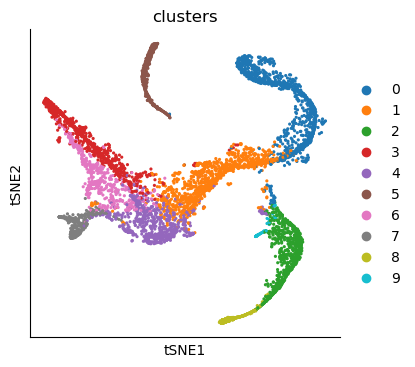

In [94]:
sc.pl.tsne(adata_bm, color="clusters")

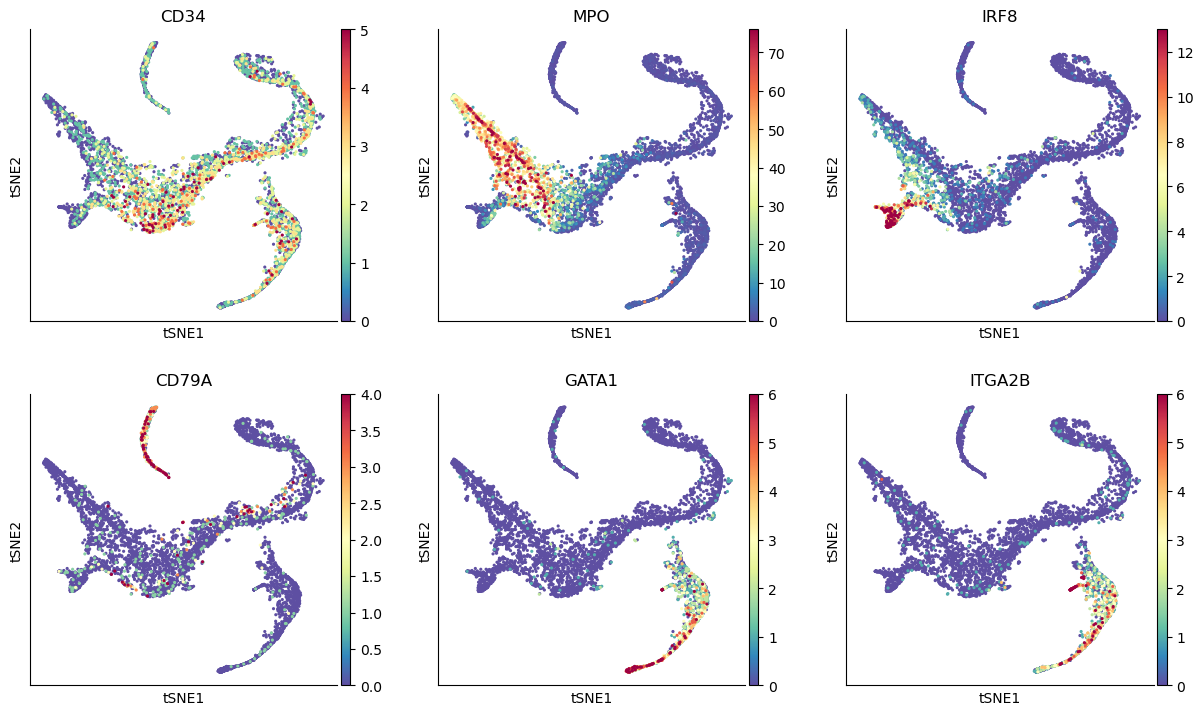

In [95]:
# Visualize some gene expression trends
genes = ["CD34", "MPO", "IRF8", "CD79A", "GATA1", "ITGA2B"]
sc.pl.tsne(adata_bm, color=genes, ncols=3, vmin="p1", vmax="p99")

In [96]:
# We are computing 300 principal components as that is what the authors used.
# The rationale was that they wanted to consider enough PCs to explain 75% of the variance in the data
# We're doing this to reproduce their results, not because we think it's a good idea
sc.tl.pca(adata_bm, n_comps=300)

In [97]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca'
    varm: 'PCs'

## Run Diffusion Maps

In [98]:
# Compute diffusion maps
sc.pp.neighbors(
    adata_bm,
    n_neighbors=30,
    use_rep="X_pca",
    metric="euclidean",
    key_added="neighbors_30",
)
sc.tl.diffmap(adata_bm, n_comps=30, neighbors_key="neighbors_30")

Text(12, 0.89, 'eigen gap')

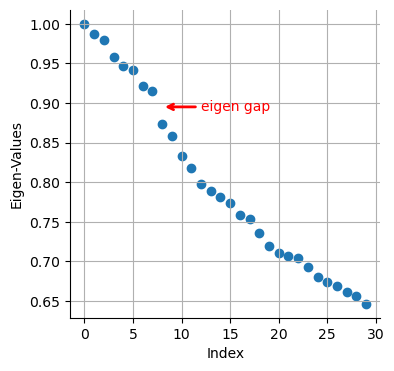

In [99]:
# Eigenvalues
plt.scatter(range(len(adata_bm.uns["diffmap_evals"])), adata_bm.uns["diffmap_evals"])
plt.grid("on")
plt.xlabel("Index")
plt.ylabel("Eigen-Values")

plt.annotate(
    "eigen gap",
    xy=(8, 0.895),  # Arrow tip
    xytext=(12, 0.89),  # Text location
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    color="red",  # Text color
)

We see a clear gap between 8th and 9th eigenvalues (note: counting starts at 0). This is indicative that the first 8 eigenvalues are the most informative about the data.

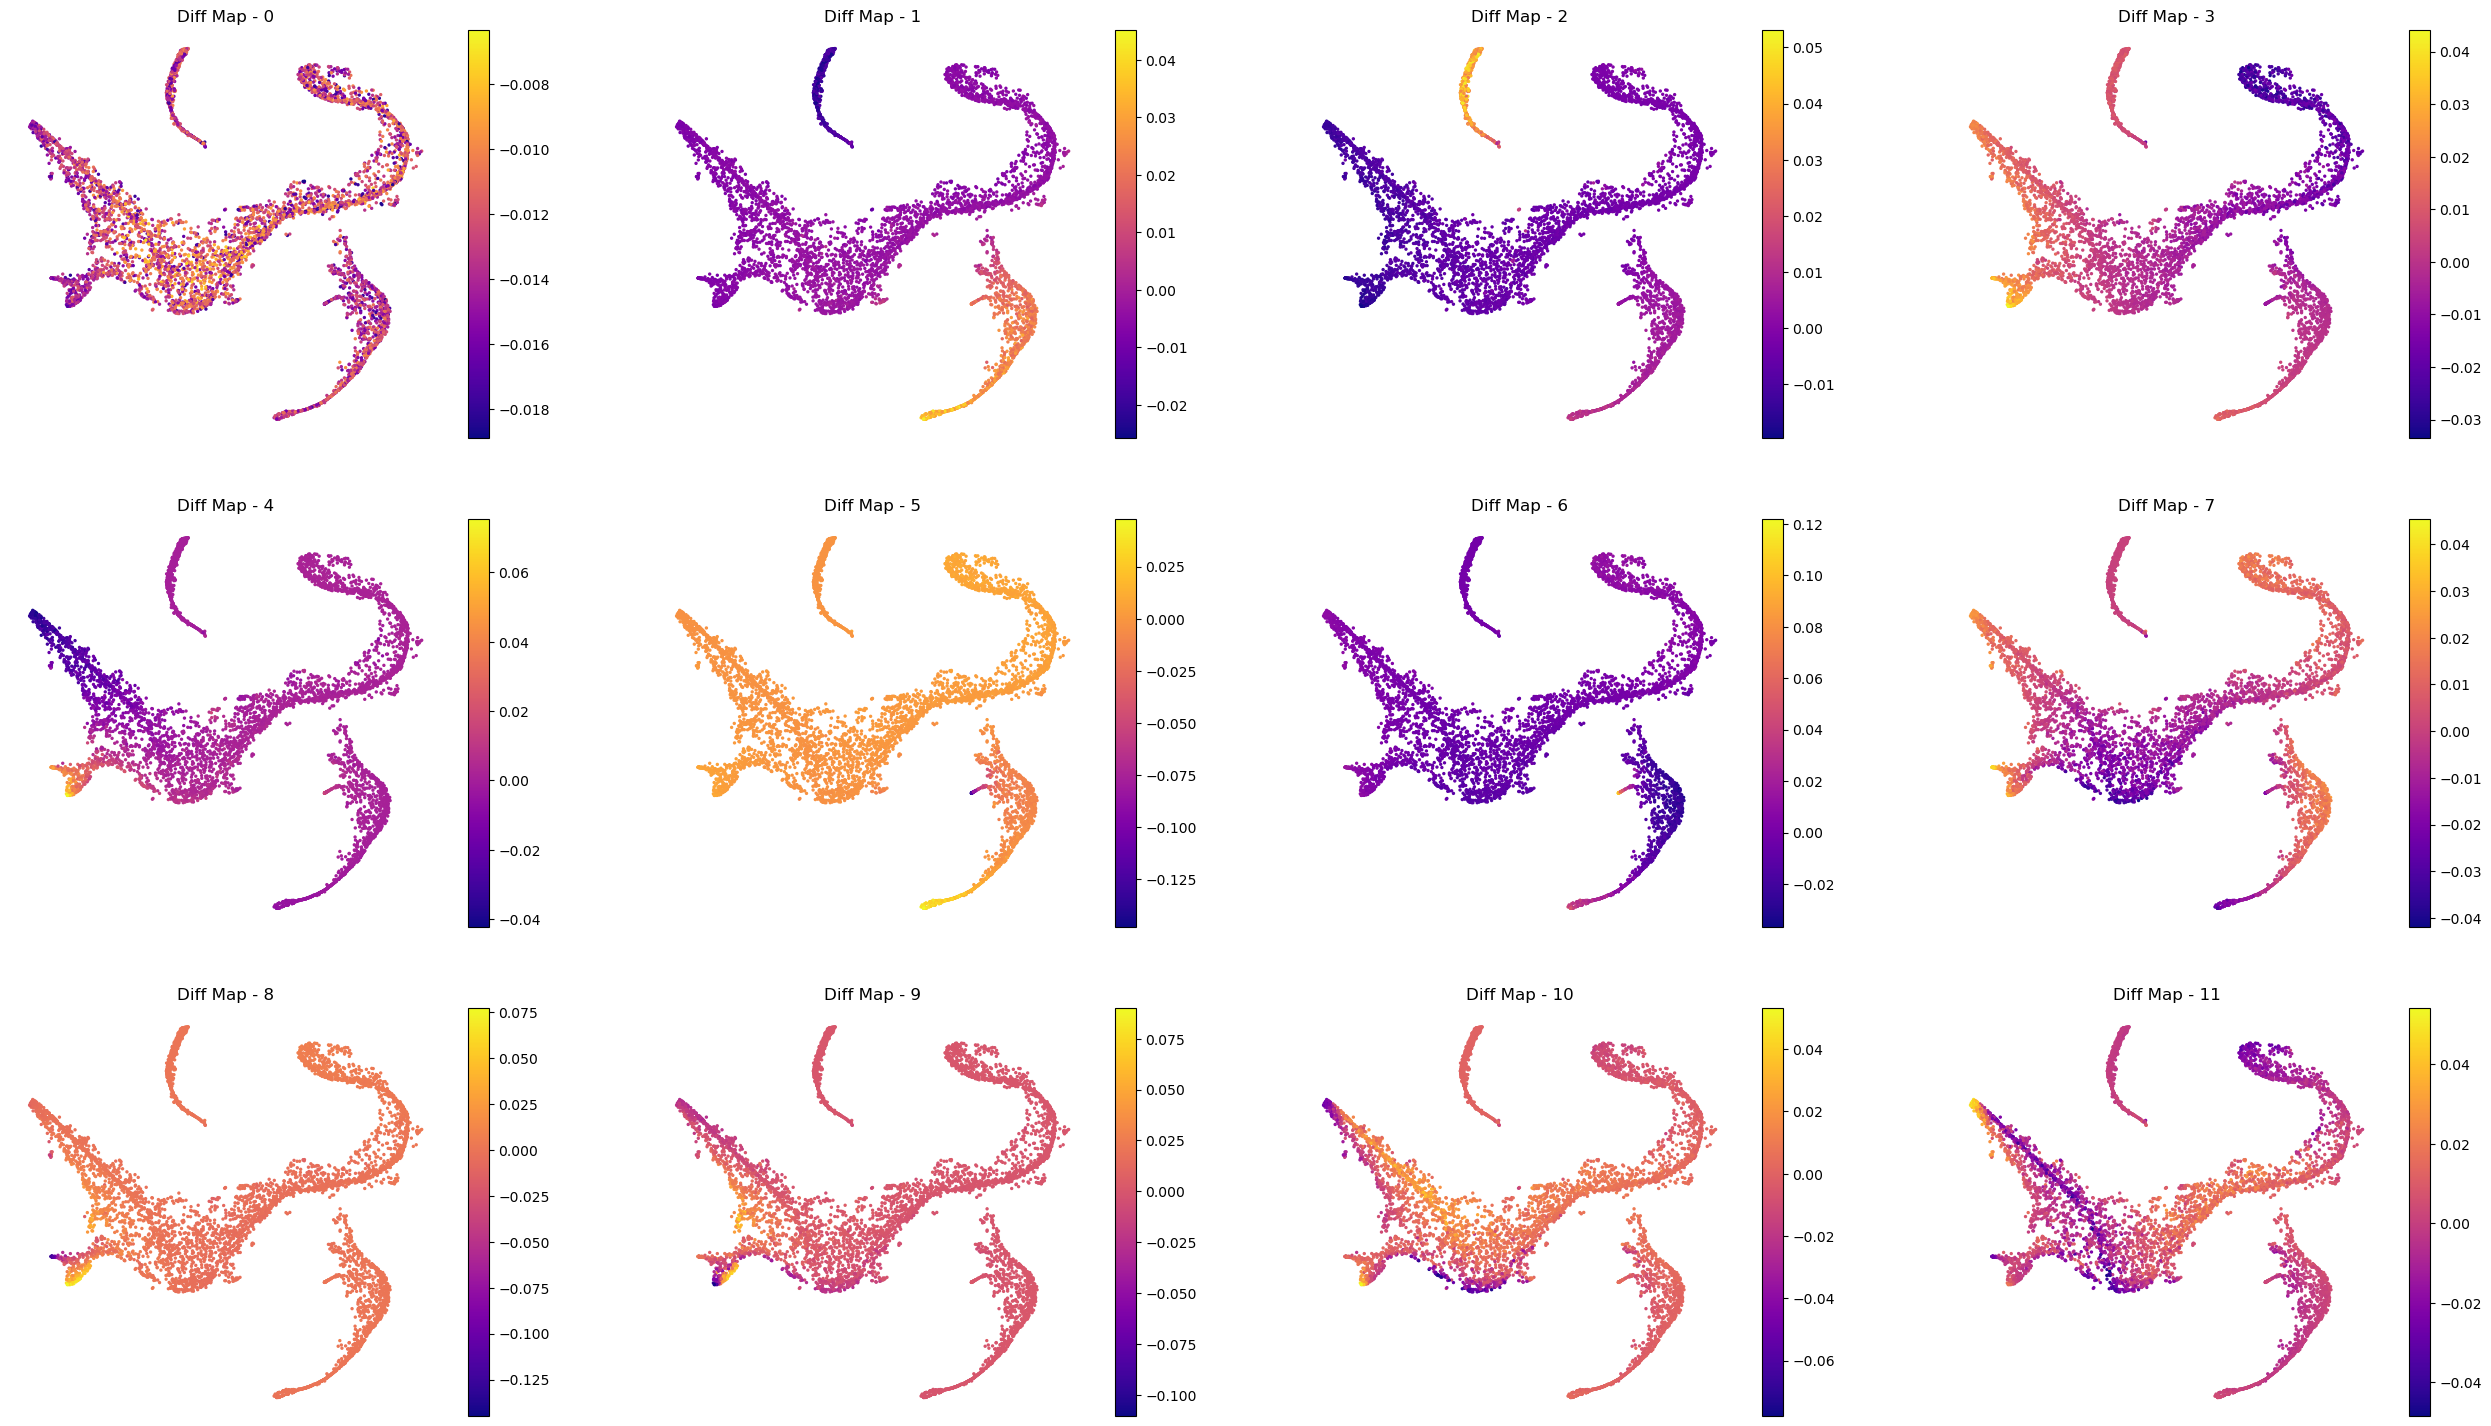

In [100]:
# Visualize the first 12 eigenvectors
ncol = 4
nrow = 3

fig = plt.figure(figsize=(8 * ncol, 6 * nrow))
for j in range(12):
    ax = fig.add_subplot(nrow, ncol, j + 1)
    im1 = ax.scatter(
        adata_bm.obsm["tsne"][:, 0],
        adata_bm.obsm["tsne"][:, 1],
        s=2,
        c=adata_bm.obsm["X_diffmap"][:, j],
        cmap="plasma",
    )
    fig.colorbar(im1)
    ax.axis("off")
    ax.set_title("Diff Map - " + str(j))

# To save:
# fig.savefig(output_directory + 'umap_colored_by_diff_maps.png', bbox_inches = 'tight', dpi = 150)

Interpreting the plots above:

1. We ignore Diff Map - 0 as we have discussed previously.
2. Diff Map - 1 tracks the progression of GATA1+ cells (Erythroid cells)
3. Diff Map - 2 tracks the progression of CD79A+ cells (Common Lymphoid Progrenitor cells)
4. Diff Map - 3 tracks the progression of IRF8+ and MPO+ cells (Dendritic cells and Monocytes)
5. Diff Map - 4 trakcs the progression of IRF8+ cells and distinguishes it from MPO+ cells (contrast with Diff Map -3)

and so forth.

As we can see, diffusion maps clearly track the major changes along the data. The above is a complex example of multiple trajectories or transitions but is a good example case that illustrates the power of diffusion maps in delineating such trajectories. 

To perform downstream analysis or interpreting the diffusion components, you can start to identify genes that are correlated (positively or negatively) with the diffusion component that you are interested in investigating. For example, we will correlate the top 10 diffusion components above with every gene and sort them based on their correlation score. First, we will provide code to correlate one diffusion component. Second, we will write a for loop to iterate it over all diffusion components of interest.

In [101]:
# Correlate with diffusion component 1 (Recall: Diff Comp 0 is to be ignored)
data = adata_bm.X
diff_1 = adata_bm.obsm["X_diffmap"][:, 1]

corr_score = np.empty(data.shape[1], dtype=np.float64)
for j in range(data.shape[1]):
    corr_temp = np.corrcoef(data[:, j], diff_1)
    corr_score[j] = corr_temp[0, 1]

In [102]:
# Arrange that in pandas data frame with associated gene names:
df_corr = pd.DataFrame({"corr_score": corr_score}, index=adata_bm.var.index)
df_corr["absolute_corr_score"] = np.abs(df_corr["corr_score"])
df_corr.head(5)

corr_score  absolute_corr_score
index                                  
A1BG     -0.167828             0.167828
A2M      -0.003106             0.003106
A2ML1     0.044154             0.044154
A4GALT    0.326926             0.326926
AAAS      0.156086             0.156086

In [103]:
# sort by absolute value of corr_score (to isolate top positively & negatively correlated genes)
df_corr.sort_values(by="absolute_corr_score", ascending=False)

corr_score  absolute_corr_score
index                                   
KLF1       0.824019             0.824019
APOC1      0.793445             0.793445
CNRIP1     0.778497             0.778497
GATA1      0.762807             0.762807
ANK1       0.748083             0.748083
...             ...                  ...
SIRPD           NaN                  NaN
SLC7A10         NaN                  NaN
SNCG            NaN                  NaN
TM4SF18         NaN                  NaN
WLS             NaN                  NaN

[14651 rows x 2 columns]

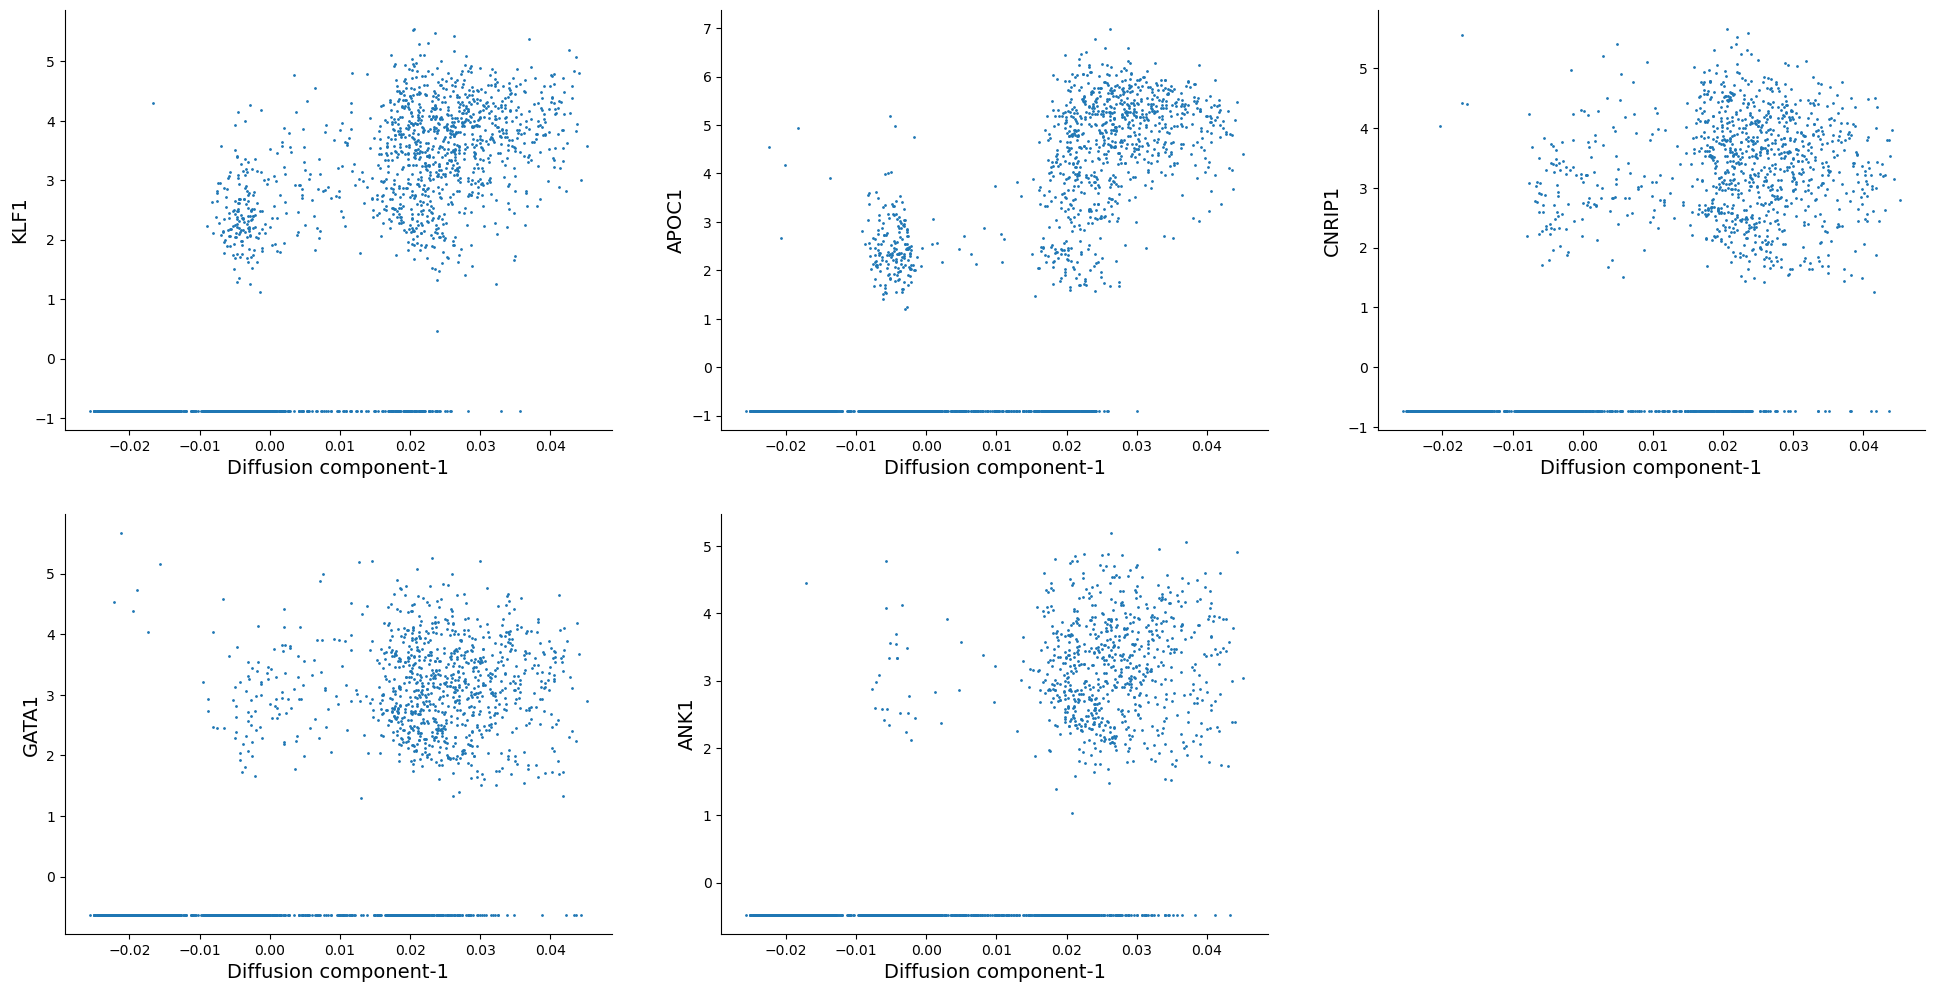

In [104]:
# Visualize the trend of top 5 genes along diffusion component 1:
top_genes = ["KLF1", "APOC1", "CNRIP1", "GATA1", "ANK1"]
fig = plt.figure(figsize=(8 * 3, 6 * 2))
for j, gene in enumerate(top_genes):
    ax = fig.add_subplot(2, 3, j + 1)
    ax.scatter(
        adata_bm.obsm["X_diffmap"][:, 1],
        adata_bm.X[:, adata_bm.var_names.get_loc(gene)],
        s=1,
    )
    ax.set_xlabel("Diffusion component-1", fontsize=14)
    ax.set_ylabel(gene, fontsize=14)

As we can see, KLF1, GATA1 are some of the highly correlated genes with diffusion component 1. Inspecting the top genes this way can help you get a sense of what each diffusion component is trying to explain.

We can now automate this for all the diffusion components of interest:

In [105]:
# Correlate with top 10 diffusion components
data = adata_bm.X

for diff_comp in range(1, 11):
    print(f"Calculating correlation for diffusion component: {diff_comp}")
    diff_temp = adata_bm.obsm["X_diffmap"][:, diff_comp]
    corr_score = np.empty(data.shape[1], dtype=np.float64)
    for j in range(data.shape[1]):
        corr_temp = np.corrcoef(data[:, j], diff_temp)
        corr_score[j] = corr_temp[0, 1]

    df_corr = pd.DataFrame({"corr_score": corr_score}, index=adata_bm.var.index)
    df_corr["absolute_corr_score"] = np.abs(df_corr["corr_score"])

    # save as csv:
    # df_corr.to_csv(output_directory + 'gene_correlation_with_diffusion_comp_' + str(diff_comp) + '.csv')

Calculating correlation for diffusion component: 1
Calculating correlation for diffusion component: 2
Calculating correlation for diffusion component: 3
Calculating correlation for diffusion component: 4
Calculating correlation for diffusion component: 5
Calculating correlation for diffusion component: 6
Calculating correlation for diffusion component: 7
Calculating correlation for diffusion component: 8
Calculating correlation for diffusion component: 9
Calculating correlation for diffusion component: 10


## Palantir

Palantir is a graph-based method to align differentiating cells onto a pseudotime axis. Palantir models the differentiation landscape as a continuum (as opposed to a set of discrete stages) and aligns cells along an axis, automatically identifies and characterizes the terminal differentiated states, and assigns each cell a probablity of differentiating into one of the terminal states. 

The key inputs to the method are:

1. scRNA-seq data from a differentiating system
2. Start cell, i.e. where the differentiation starts
3. `k` or `n_neighbors` for graph construction.

We again recommend that you investigate and ensure that your pseudotime and branch probability results are robust to slight variations around input 2 and 3. You can consult Supplementary Figures 5-8 in the reference below:

Ref: https://www.nature.com/articles/s41587-019-0068-4

While palantir is integrated into scanpy as `sc.external.tl.palantir`, we suggest you import palantir by itself. The authors have made modifications for easier downstream analysis, which may not be up to date in Scanpy.

In [106]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

As part of the analysis, palantir first computes diffusion maps on the data, then scales the diffusion components based on their eigenvalues (please see the manuscript for more details). Then it uses the rescaled diffusion components to build the pseudotime.

In [107]:
import palantir

In [108]:
# first compute diffusion maps
palantir.utils.run_diffusion_maps(adata_bm, n_components=20);

In [109]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

Text(12, 0.83, 'eigen gap')

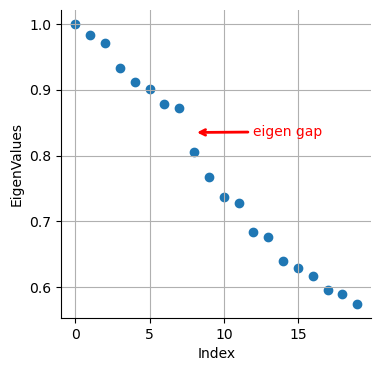

In [110]:
# visualize the eigenvalues:
plt.scatter(range(len(adata_bm.uns["DM_EigenValues"])), adata_bm.uns["DM_EigenValues"])
plt.xlabel("Index")
plt.ylabel("EigenValues")
plt.grid("on")


plt.annotate(
    "eigen gap",
    xy=(8, 0.835),  # Arrow tip
    xytext=(12, 0.83),  # Text location
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
    color="red",  # Text color
)

Like before we see a gap between 8th and 9th eigenvalues. Now, palantir will use this result to rescale the top N eigenvectors, which are chosen automatically (but can also be userdefined) based on the gap between eigenvalues as shown above.

In [111]:
palantir.utils.determine_multiscale_space(adata_bm);

In [112]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'PCs'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

In [113]:
adata_bm.obsm["DM_EigenVectors_multiscaled"].shape

(5780, 7)

As we suspected, palantir considered the first 8 eigenvectors (and it removes the 0th eigenvector) as the most meaningful and rescaled them based on their eigenvalues (for more details, please see the manuscript).

Color tSNE by top 8 diffusion maps:

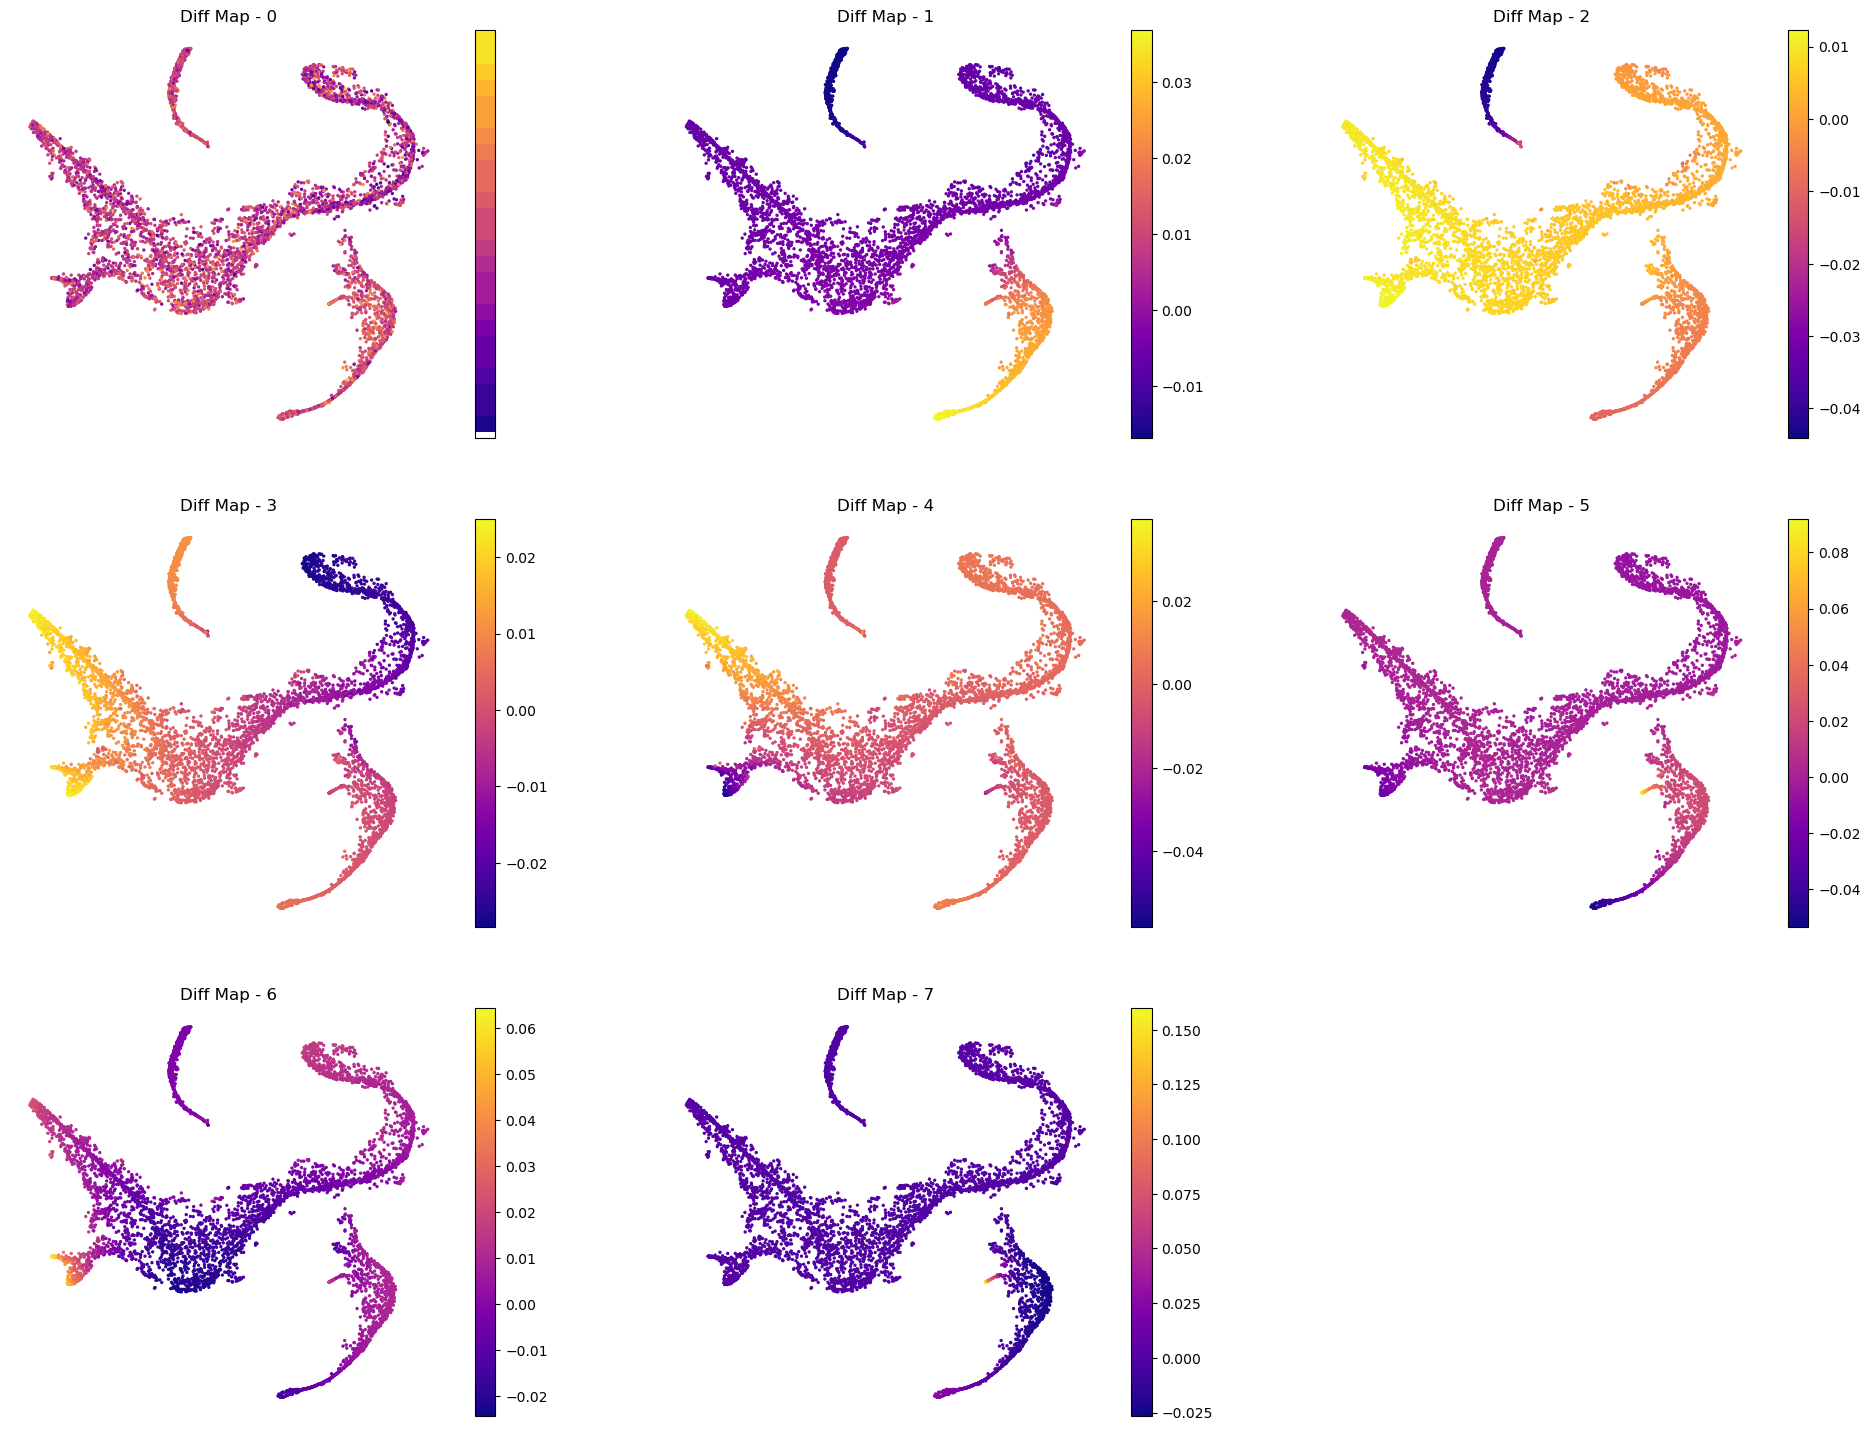

In [114]:
# Visualize the first 8 eigenvectors
ncol = 3
nrow = 3

fig = plt.figure(figsize=(8 * ncol, 6 * nrow))
for j in range(8):
    ax = fig.add_subplot(nrow, ncol, j + 1)
    im1 = ax.scatter(
        adata_bm.obsm["tsne"][:, 0],
        adata_bm.obsm["tsne"][:, 1],
        s=2,
        c=adata_bm.obsm["DM_EigenVectors"][:, j],
        cmap="plasma",
    )
    fig.colorbar(im1)
    ax.axis("off")
    ax.set_title("Diff Map - " + str(j))

# To save:
# fig.savefig(output_directory + 'umap_colored_by_diff_maps.png', bbox_inches = 'tight', dpi = 150)

Visualize genes for interpretation:

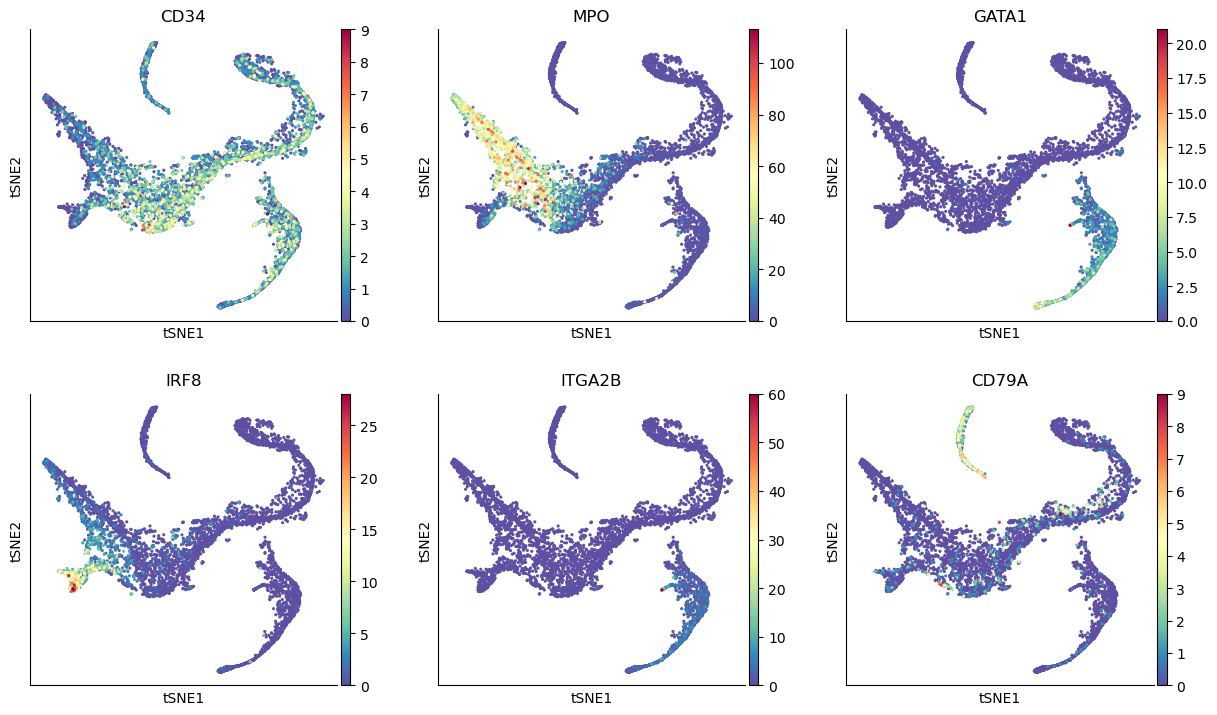

In [115]:
# Visualize some gene expression on the above tsne:
sc.pl.tsne(adata_bm, color=["CD34", "MPO", "GATA1", "IRF8", "ITGA2B", "CD79A"], ncols=3)

### Define start cell

Palantir expects that you provide an example cell as a start point. The algorithm will use this cell as the initiating point of the trajectory but with each iteration, the start cell will be refined automatically. In other words, palantir is very robust to the choice of start cell, so it is OK that you only provide an _approximate_ `start_cell`.

But how does one generally assign a start cell? This is a context dependent problem. In this data, the authors decided to find the cell with high expression of CD34 gene (the most primitive cell from Cluster 0) and define it as the start point. For this they selected a random cell from the highlighted region below. 

In [116]:
# Define a start point
# Please note that the start_cell should be the barcode of the cell estimated to be an ideal start point
start_cell = "Run5_164698952452459"

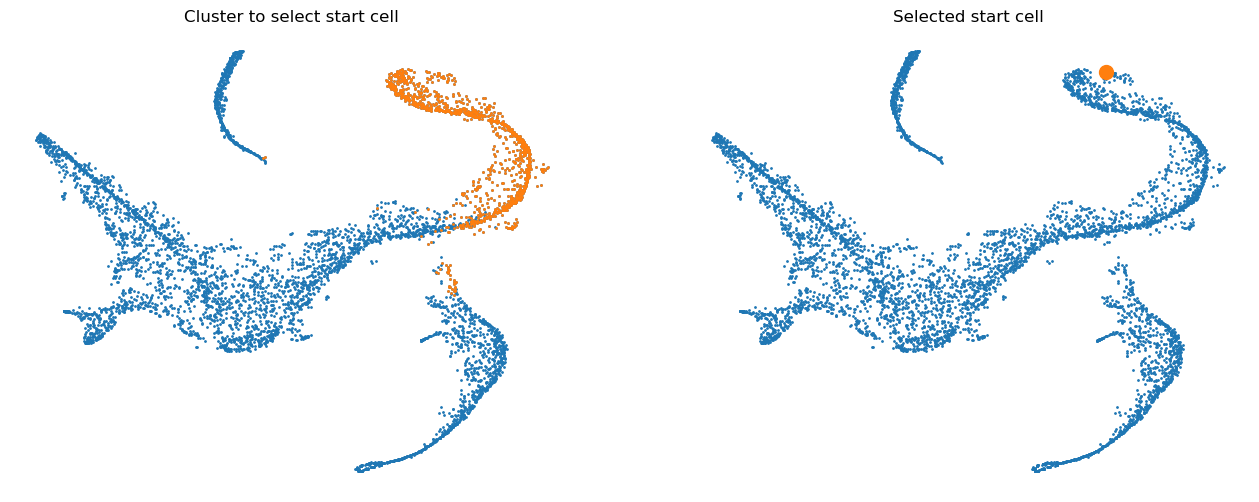

In [117]:
fig = plt.figure(figsize=(8 * 2, 6))
ax = fig.add_subplot(1, 2, 1)
select_cells = adata_bm.obs["clusters"] == "0"
ax.scatter(adata_bm.obsm["X_tsne"][:, 0], adata_bm.obsm["X_tsne"][:, 1], s=1)
ax.scatter(
    adata_bm.obsm["X_tsne"][select_cells, 0],
    adata_bm.obsm["X_tsne"][select_cells, 1],
    s=1,
)
ax.axis("off")
ax.set_title("Cluster to select start cell")

ax = fig.add_subplot(1, 2, 2)
select_cells = adata_bm.obs_names.get_loc(start_cell)
ax.scatter(adata_bm.obsm["X_tsne"][:, 0], adata_bm.obsm["X_tsne"][:, 1], s=1)
ax.scatter(
    adata_bm.obsm["X_tsne"][select_cells, 0],
    adata_bm.obsm["X_tsne"][select_cells, 1],
    s=100,
)
ax.axis("off")
ax.set_title("Selected start cell");

### Define terminal states

Palantir can automatically identify the terminal points, so you can begin your analysis by seeing what palantir identifies as terminal state(s). However, if you want to use biological intuition to identify possible terminal states, you can specify the cells which you think are likely terminal states. 

If you want a data driven way to identify potential terminal states then you can study the cells with the minimum and maximum values of the diffusion components. Since Palantir builds on the diffusion components, you can study the components itself to identify potential end states. Now, we will color the tSNE by diffusion components, and highlight the cells with min and max values for each component. 

Note: we only look at the first 8 diffusion component because the gap in eigenvalues is highest there, meaning that palantir will focus on these 8 components to derive a pseudotime.

In [118]:
adata_bm.obsm["DM_EigenVectors_multiscaled"].shape

(5780, 7)

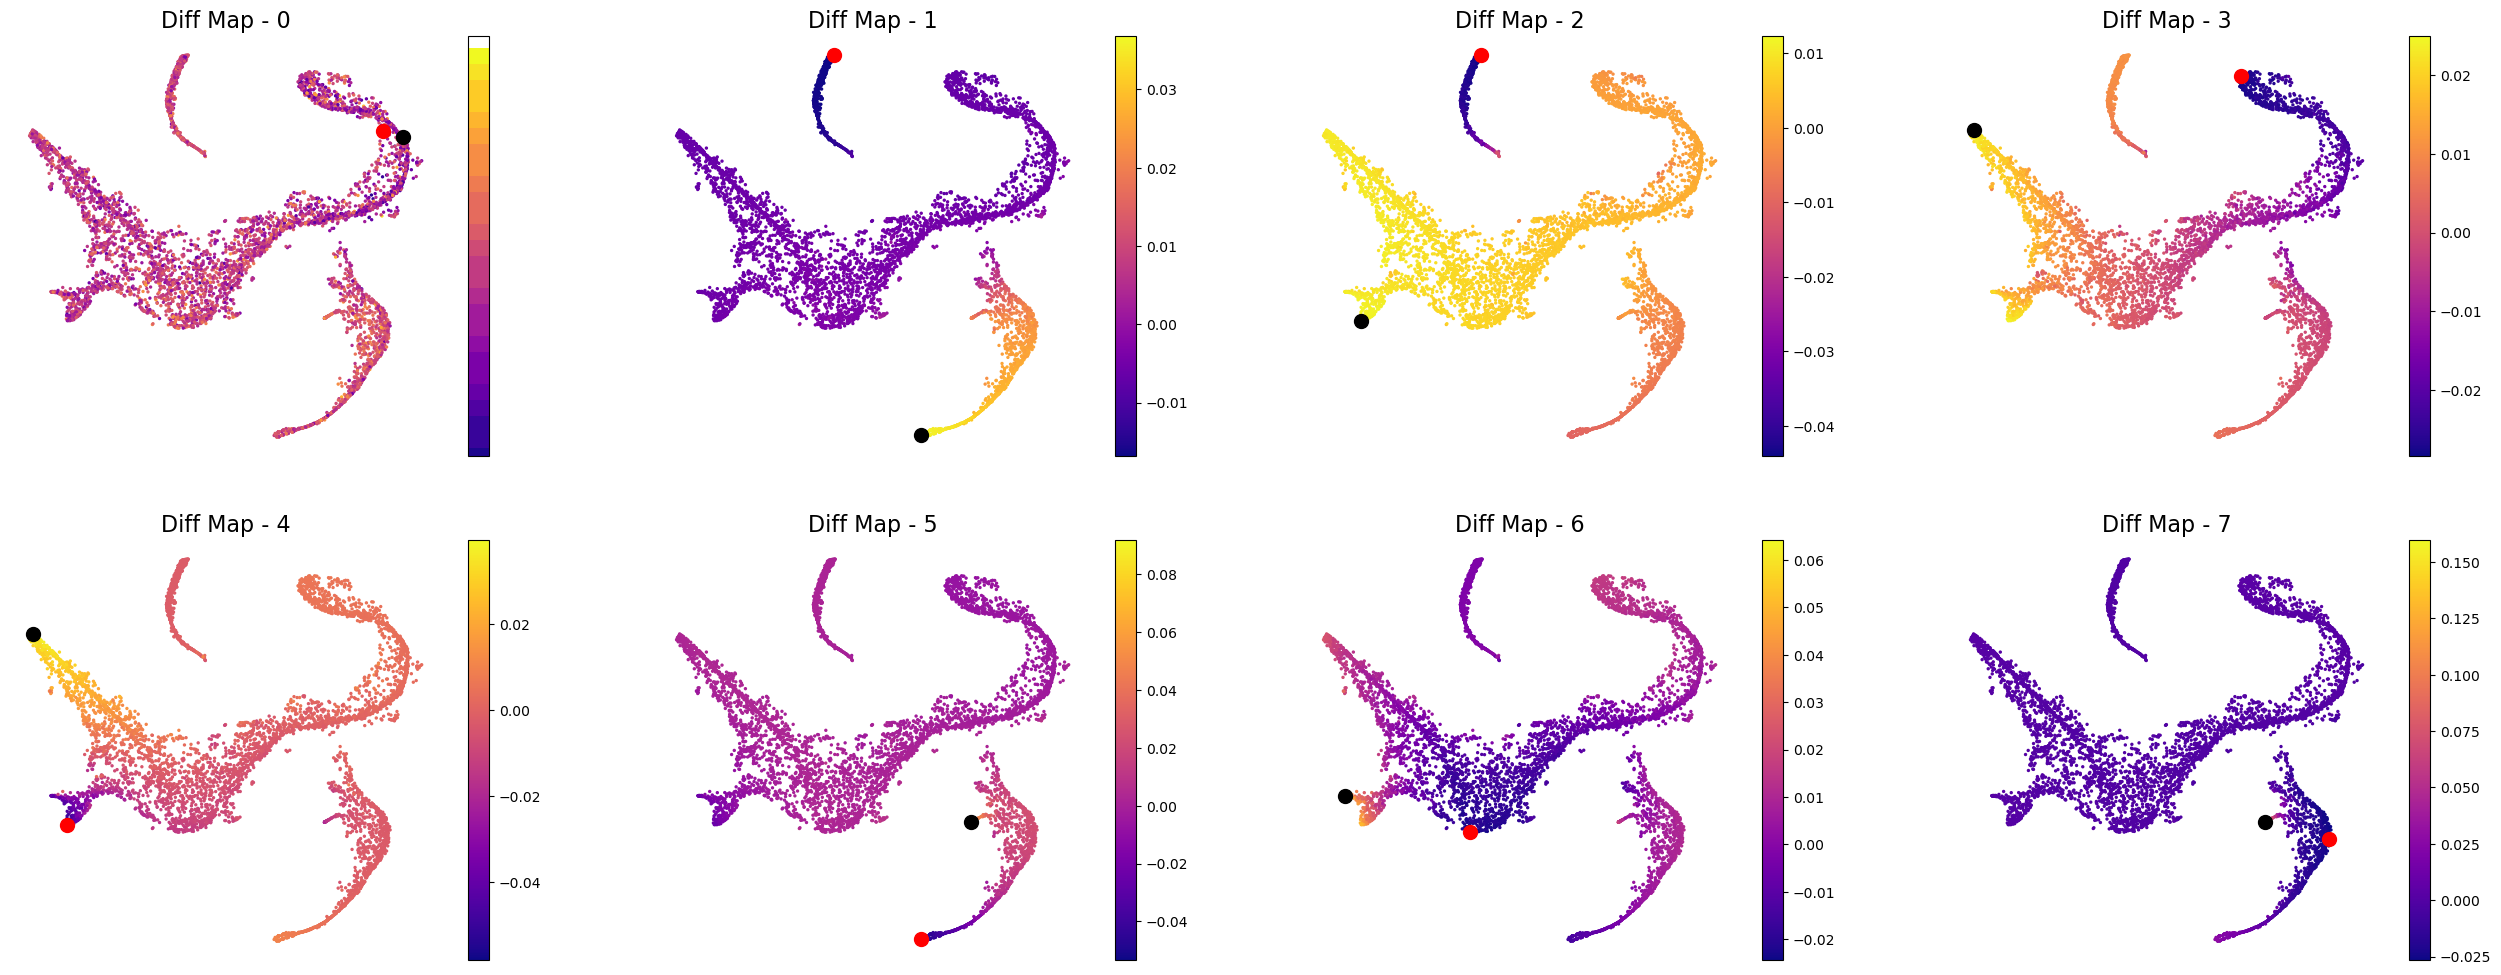

In [119]:
# Visualize the first 8 eigenvectors (Note: we ignore the 0th so 7 really)
ncol = 4
nrow = 2

fig = plt.figure(figsize=(8 * ncol, 6 * nrow))
for j in range(8):
    ax = fig.add_subplot(nrow, ncol, j + 1)
    im1 = ax.scatter(
        adata_bm.obsm["tsne"][:, 0],
        adata_bm.obsm["tsne"][:, 1],
        s=2,
        c=adata_bm.obsm["DM_EigenVectors"][:, j],
        cmap="plasma",
    )

    [id_min, id_max] = np.argsort(adata_bm.obsm["DM_EigenVectors"][:, j])[[0, -1]]

    ax.scatter(
        adata_bm.obsm["tsne"][id_min, 0], adata_bm.obsm["tsne"][id_min, 1], s=100, c="r"
    )

    ax.scatter(
        adata_bm.obsm["tsne"][id_max, 0], adata_bm.obsm["tsne"][id_max, 1], s=100, c="k"
    )

    fig.colorbar(im1)
    ax.axis("off")
    ax.set_title("Diff Map - " + str(j), fontsize=16)

# To save:
# fig.savefig(output_directory + 'umap_colored_by_diff_maps.png', bbox_inches = 'tight', dpi = 150)

In the plot above the tsne representation of the data is colored by each diffusion component. The cells with minimum value for the diffusion component is highlighted in red, while the cells with the maximum value for the diffusion component is highlighted is black. For the plots above, we can speculate that the potential terminal states are as follows after taking care of duplicates:

1) min and max of diffusion component 1

2) max of diffusion component 2

3) max of diffusion component 3

4) max of diffusion component 5

5) max of diffusion component 6

We are making this claim, also based on the gene expression and cell types in each of these terminal states. So, when you adapt this code for your own data, we suggest that you study your data based on gene expression and as above where we looked at the cells with minimum and maximum values for each diffusion component.

Let's get the cell barcode for the cells corresponding to the minimum and maximum values of the above mentioned diffusion components. 

In [120]:
terminal_states = []

# for component 1
cell_comp1 = np.argsort(adata_bm.obsm["DM_EigenVectors"][:, 1])[[0, -1]]
terminal_states = terminal_states + list(adata_bm.obs_names[cell_comp1])

# for component 2
cell_comp2 = np.argsort(adata_bm.obsm["DM_EigenVectors"][:, 2])[-1]
terminal_states.append(adata_bm.obs_names[cell_comp2])


# for component 3
cell_comp3 = np.argsort(adata_bm.obsm["DM_EigenVectors"][:, 3])[-1]
terminal_states.append(adata_bm.obs_names[cell_comp3])

# for component 5
cell_comp5 = np.argsort(adata_bm.obsm["DM_EigenVectors"][:, 5])[-1]
terminal_states.append(adata_bm.obs_names[cell_comp5])

# for component 6
cell_comp6 = np.argsort(adata_bm.obsm["DM_EigenVectors"][:, 6])[-1]
terminal_states.append(adata_bm.obs_names[cell_comp6])

In [121]:
terminal_states

['Run4_239448276221238',
 'Run4_236650105264556',
 'Run5_239477254471070',
 'Run4_130736318737710',
 'Run5_191691434420467',
 'Run4_200967489997038']

Visualize start and terminal states on tsne:

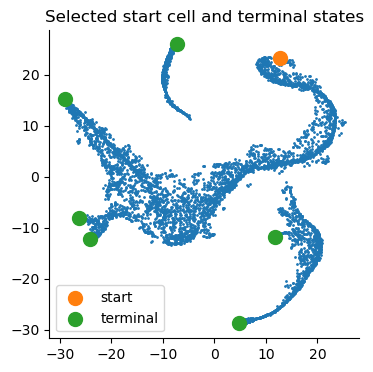

In [122]:
select_cell_start = adata_bm.obs_names.get_loc(start_cell)
select_cell_terminal = [adata_bm.obs_names.get_loc(j) for j in terminal_states]

plt.scatter(adata_bm.obsm["X_tsne"][:, 0], adata_bm.obsm["X_tsne"][:, 1], s=1)
plt.scatter(
    adata_bm.obsm["X_tsne"][select_cell_start, 0],
    adata_bm.obsm["X_tsne"][select_cell_start, 1],
    s=100,
    label="start",
)
plt.scatter(
    adata_bm.obsm["X_tsne"][select_cell_terminal, 0],
    adata_bm.obsm["X_tsne"][select_cell_terminal, 1],
    s=100,
    label="terminal",
)
plt.title("Selected start cell and terminal states")
plt.legend()

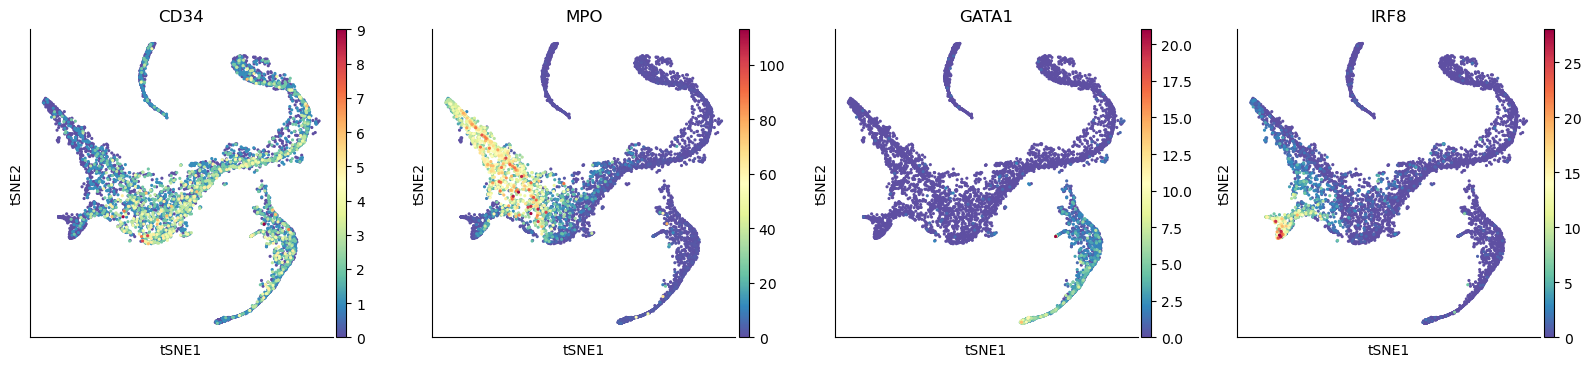

In [123]:
# Visualize some gene expression on the above tsne:
sc.pl.tsne(adata_bm, color=["CD34", "MPO", "GATA1", "IRF8"])

### Compute pseudotime

In [124]:
pr_res = palantir.core.run_palantir(
    adata_bm, early_cell=start_cell, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0038289984067281088 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.0444769819577535 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9996
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [125]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities'
    varm: 'PCs'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

Now to further process pr_res, we will follow: https://nbviewer.org/github/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

Palantir generates the following results

- `palantir_pseudotime`: Pseudo time ordering of each cell
- `palantir_fate_probabilities`: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
- `palantir_entropy`: A quantiative measure of the differentiation potential of each cell computed as the entropy of the multinomial terminal state probabilities

### Get the pseudotime

In [126]:
adata_bm.obs["palantir_pseudotime"]

index
Run4_120703408880541    0.550816
Run4_120703409056541    0.075164
Run4_120703409580963    0.754491
Run4_120703423990708    0.721940
Run4_120703424252854    0.560269
                          ...   
Run5_241114589051630    0.856934
Run5_241114589051819    0.414087
Run5_241114589128940    0.455159
Run5_241114589357942    0.887660
Run5_241114589841822    0.470197
Name: palantir_pseudotime, Length: 5780, dtype: float64

In the output above, each row is a cell barcode and the number associated with each cell is it's pseudotime alignment score (between 0 representing early and 1 representing differentiated).

In [127]:
# Get the branch probabilities
# As shown below, palantir used the 6 terminally differentiated states
adata_bm.obsm["palantir_fate_probabilities"]

Run4_130736318737710  Run4_200967489997038  \
index                                                              
Run4_120703408880541              0.149151              0.033019   
Run4_120703409056541              0.358160              0.079070   
Run4_120703409580963              0.932721              0.011899   
Run4_120703423990708              0.870284              0.022942   
Run4_120703424252854              0.382526              0.120841   
...                                    ...                   ...   
Run5_241114589051630              0.021784              0.000000   
Run5_241114589051819              0.404135              0.089524   
Run5_241114589128940              0.384810              0.085456   
Run5_241114589357942              0.013484              0.000000   
Run5_241114589841822              0.410071              0.091316   

                      Run4_236650105264556  Run4_239448276221238  \
index                                                              
Run4_120703408880541              0.711654               0.00000   
Run4_120703409056541              0.353730               0.01509   
Run4_120703409580963              0.027868               0.00000   
Run4_120703423990708              0.053730               0.00000   
Run4_120703424252854              0.225036               0.00000   
...                                    ...                   ...   
Run5_241114589051630              0.957878               0.00000   
Run5_241114589051819              0.288705               0.00000   
Run5_241114589128940              0.317642               0.00000   
Run5_241114589357942              0.973926               0.00000   
Run5_241114589841822              0.278851               0.00000   

                      Run5_191691434420467  Run5_239477254471070  
index                                                             
Run4_120703408880541              0.036078              0.066004  
Run4_120703409056541              0.035894              0.158056  
Run4_120703409580963              0.000000              0.023786  
Run4_120703423990708              0.000000              0.045860  
Run4_120703424252854              0.023094              0.241555  
...                                    ...                   ...  
Run5_241114589051630              0.000000              0.000000  
Run5_241114589051819              0.029600              0.178953  
Run5_241114589128940              0.032817              0.170822  
Run5_241114589357942              0.000000              0.000000  
Run5_241114589841822              0.028615              0.182536  

[5780 rows x 6 columns]

In [128]:
# You can rename the different branches:
adata_bm.obsm["palantir_fate_probabilities"].columns = [
    "Branch1",
    "Branch2",
    "Branch3",
    "Branch4",
    "Branch5",
    "Branch6",
]

In [129]:
# Get the entropy
adata_bm.obs["palantir_entropy"]

index
Run4_120703408880541    0.960267
Run4_120703409056541    1.410281
Run4_120703409580963    0.329250
Run4_120703423990708    0.545309
Run4_120703424252854    1.423316
                          ...   
Run5_241114589051630    0.227170
Run5_241114589051819    1.395672
Run5_241114589128940    1.396320
Run5_241114589357942    0.153339
Run5_241114589841822    1.393316
Name: palantir_entropy, Length: 5780, dtype: float64

### Visualize the pseudotime

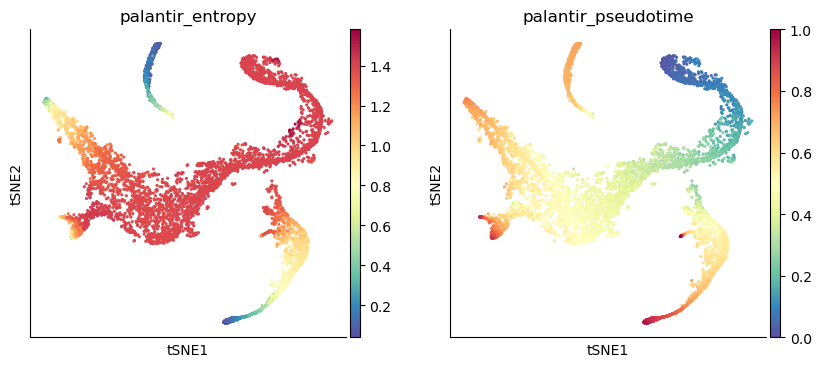

In [130]:
sc.pl.tsne(adata_bm, color=["palantir_entropy", "palantir_pseudotime"])

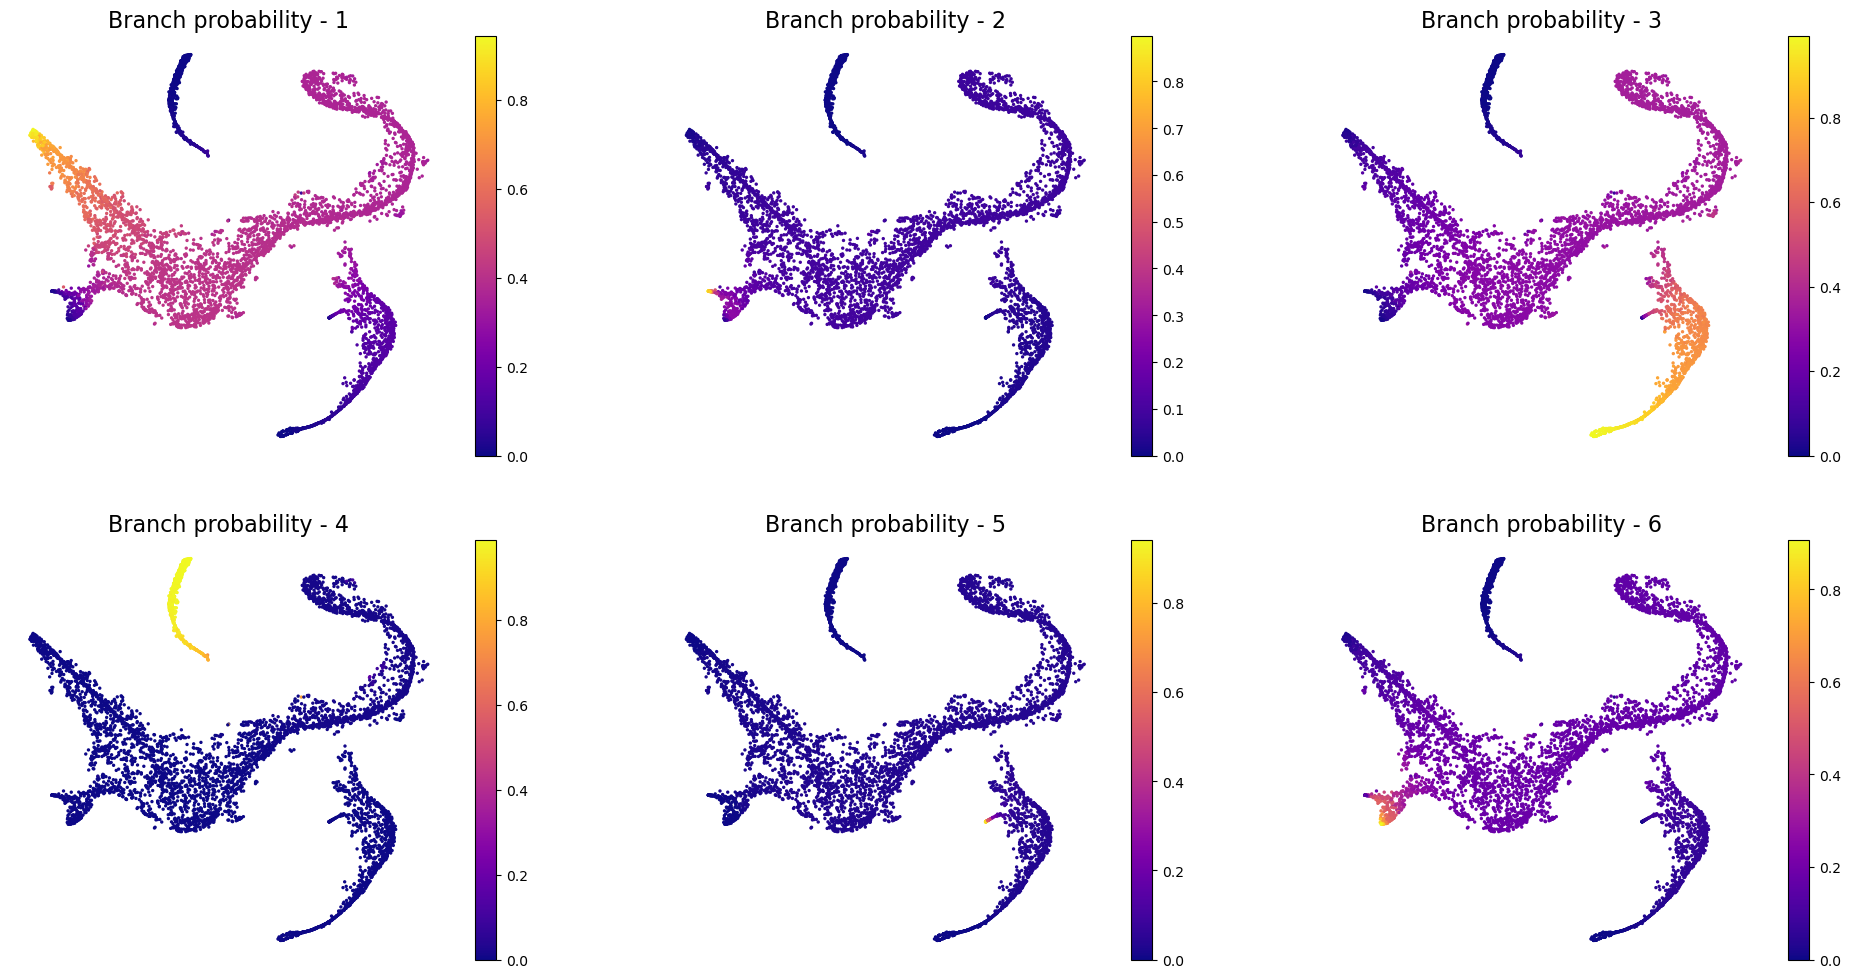

In [131]:
# Visualize branch probability
nrow = 2
ncol = 3
fig = plt.figure(figsize=(8 * ncol, 6 * nrow))
for j, item in enumerate(pr_res.branch_probs.columns):
    ax = fig.add_subplot(nrow, ncol, j + 1)
    im1 = ax.scatter(
        adata_bm.obsm["X_tsne"][:, 0],
        adata_bm.obsm["X_tsne"][:, 1],
        c=adata_bm.obsm["palantir_fate_probabilities"][item],
        s=2,
        cmap="plasma",
    )
    ax.axis("off")
    ax.set_title("Branch probability - " + str(j + 1), fontsize=16)
    fig.colorbar(im1)

### Visualize the probability for cells to reach certain terminal state

Text(0.5, 1.0, 'Run4_121896095574750')

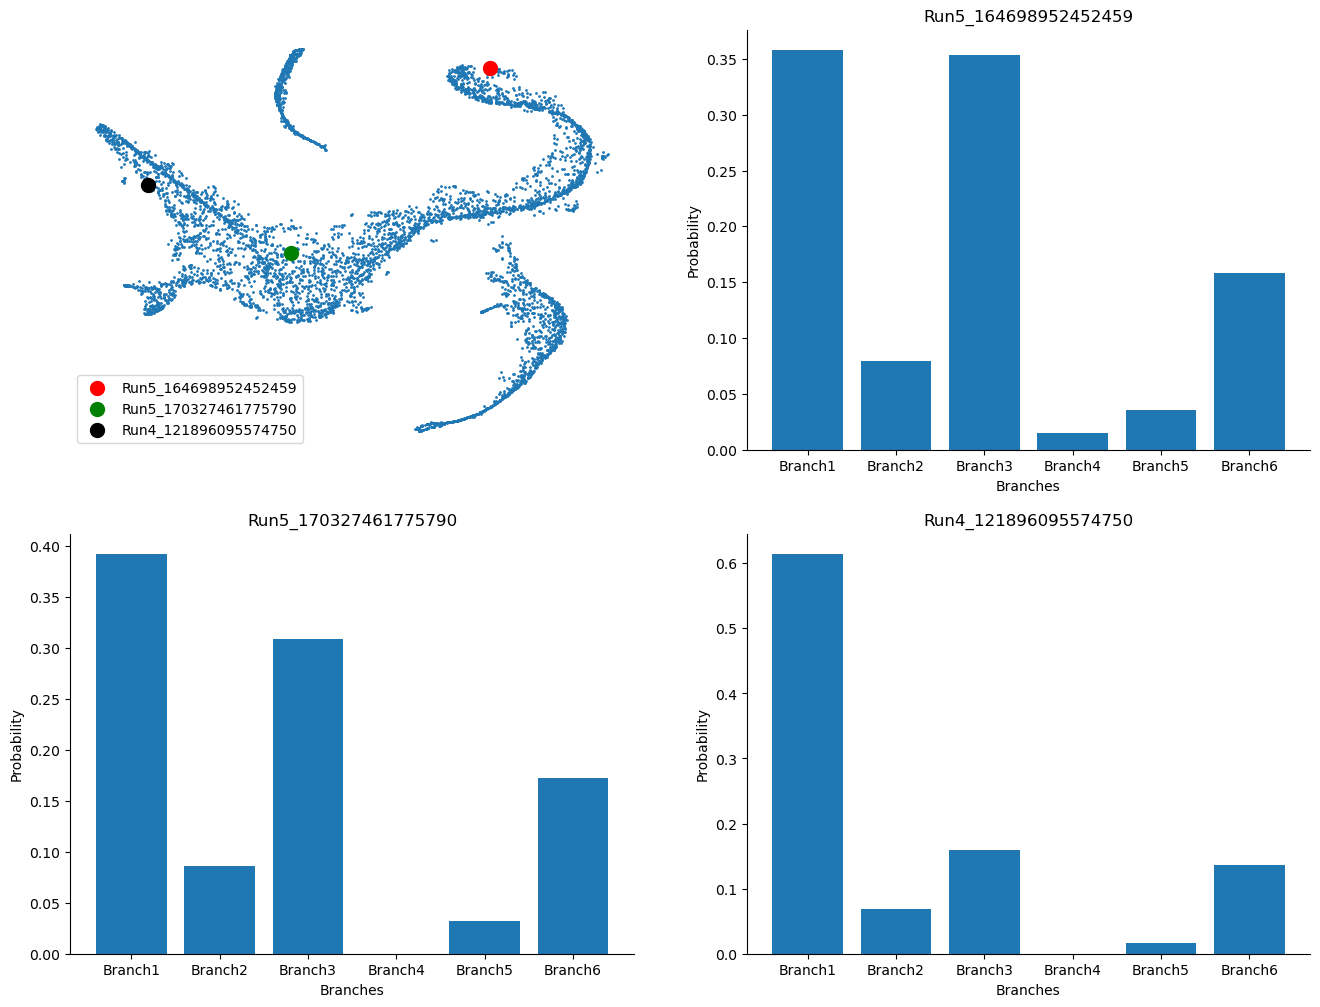

In [132]:
example_cells = ["Run5_164698952452459", "Run5_170327461775790", "Run4_121896095574750"]
fig = plt.figure(figsize=(8 * 2, 6 * 2))
ax = fig.add_subplot(2, 2, 1)
cell_id = [adata_bm.obs_names.get_loc(k) for k in example_cells]
ax.scatter(adata_bm.obsm["X_tsne"][:, 0], adata_bm.obsm["X_tsne"][:, 1], s=1)
ax.scatter(
    adata_bm.obsm["X_tsne"][cell_id[0], 0],
    adata_bm.obsm["X_tsne"][cell_id[0], 1],
    s=100,
    c="r",
    label=example_cells[0],
)
ax.scatter(
    adata_bm.obsm["X_tsne"][cell_id[1], 0],
    adata_bm.obsm["X_tsne"][cell_id[1], 1],
    s=100,
    c="g",
    label=example_cells[1],
)
ax.scatter(
    adata_bm.obsm["X_tsne"][cell_id[2], 0],
    adata_bm.obsm["X_tsne"][cell_id[2], 1],
    s=100,
    c="k",
    label=example_cells[2],
)
ax.axis("off")
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.bar(
    adata_bm.obsm["palantir_fate_probabilities"].columns,
    adata_bm.obsm["palantir_fate_probabilities"].loc[example_cells[0]],
)
ax.set_xlabel("Branches")
ax.set_ylabel("Probability")
ax.set_title(example_cells[0])

ax = fig.add_subplot(2, 2, 3)
ax.bar(
    adata_bm.obsm["palantir_fate_probabilities"].columns,
    adata_bm.obsm["palantir_fate_probabilities"].loc[example_cells[1]],
)
ax.set_xlabel("Branches")
ax.set_ylabel("Probability")
ax.set_title(example_cells[1])

ax = fig.add_subplot(2, 2, 4)
ax.bar(
    adata_bm.obsm["palantir_fate_probabilities"].columns,
    adata_bm.obsm["palantir_fate_probabilities"].loc[example_cells[2]],
)
ax.set_xlabel("Branches")
ax.set_ylabel("Probability")
ax.set_title(example_cells[2])

### Visualize gene expression trends

Palantir allows us to study the gene expression trends along each of the branches or the pseudotime. This can help us identify regions along the pseudotime when gene expression change substantially, which can be informative about the biology of the system.  

First, you can choose a branch to highlight:

In [133]:
masks = palantir.presults.select_branch_cells(adata_bm, eps=0)

In [134]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

In [135]:
adata_bm.obsm["branch_masks"]

Branch1  Branch2  Branch3  Branch4  Branch5  Branch6
index                                                                     
Run4_120703408880541    False    False     True    False    False    False
Run4_120703409056541     True     True    False    False    False     True
Run4_120703409580963     True    False    False    False    False    False
Run4_120703423990708     True    False    False    False    False    False
Run4_120703424252854    False    False    False    False    False    False
...                       ...      ...      ...      ...      ...      ...
Run5_241114589051630    False    False     True    False    False    False
Run5_241114589051819    False    False    False    False    False    False
Run5_241114589128940    False    False    False    False    False    False
Run5_241114589357942    False    False     True    False    False    False
Run5_241114589841822    False    False    False    False    False    False

[5780 rows x 6 columns]

Visualizing the branch selection:

In [136]:
help(palantir.plot.plot_branch_selection)

Help on function plot_branch_selection in module palantir.plot:

plot_branch_selection(ad: anndata._core.anndata.AnnData, pseudo_time_key: str = 'palantir_pseudotime', fate_prob_key: str = 'palantir_fate_probabilities', masks_key: str = 'branch_masks', fates: Union[List[str], str, NoneType] = None, embedding_basis: str = 'X_umap', figsize: Tuple[float, float] = (15, 5), **kwargs)
    Plot cells along specific fates of pseudotime ordering and the UMAP embedding.
    
    Parameters
    ----------
    ad : AnnData
        Annotated data matrix. The pseudotime and fate probabilities should be stored under the keys provided.
    pseudo_time_key : str, optional
        Key to access the pseudotime from obs of the AnnData object. Default is 'palantir_pseudotime'.
    fate_prob_key : str, optional
        Key to access the fate probabilities from obsm of the AnnData object.
        Default is 'palantir_fate_probabilities'.
    masks_key : str, optional
        Key to access the branch cell se

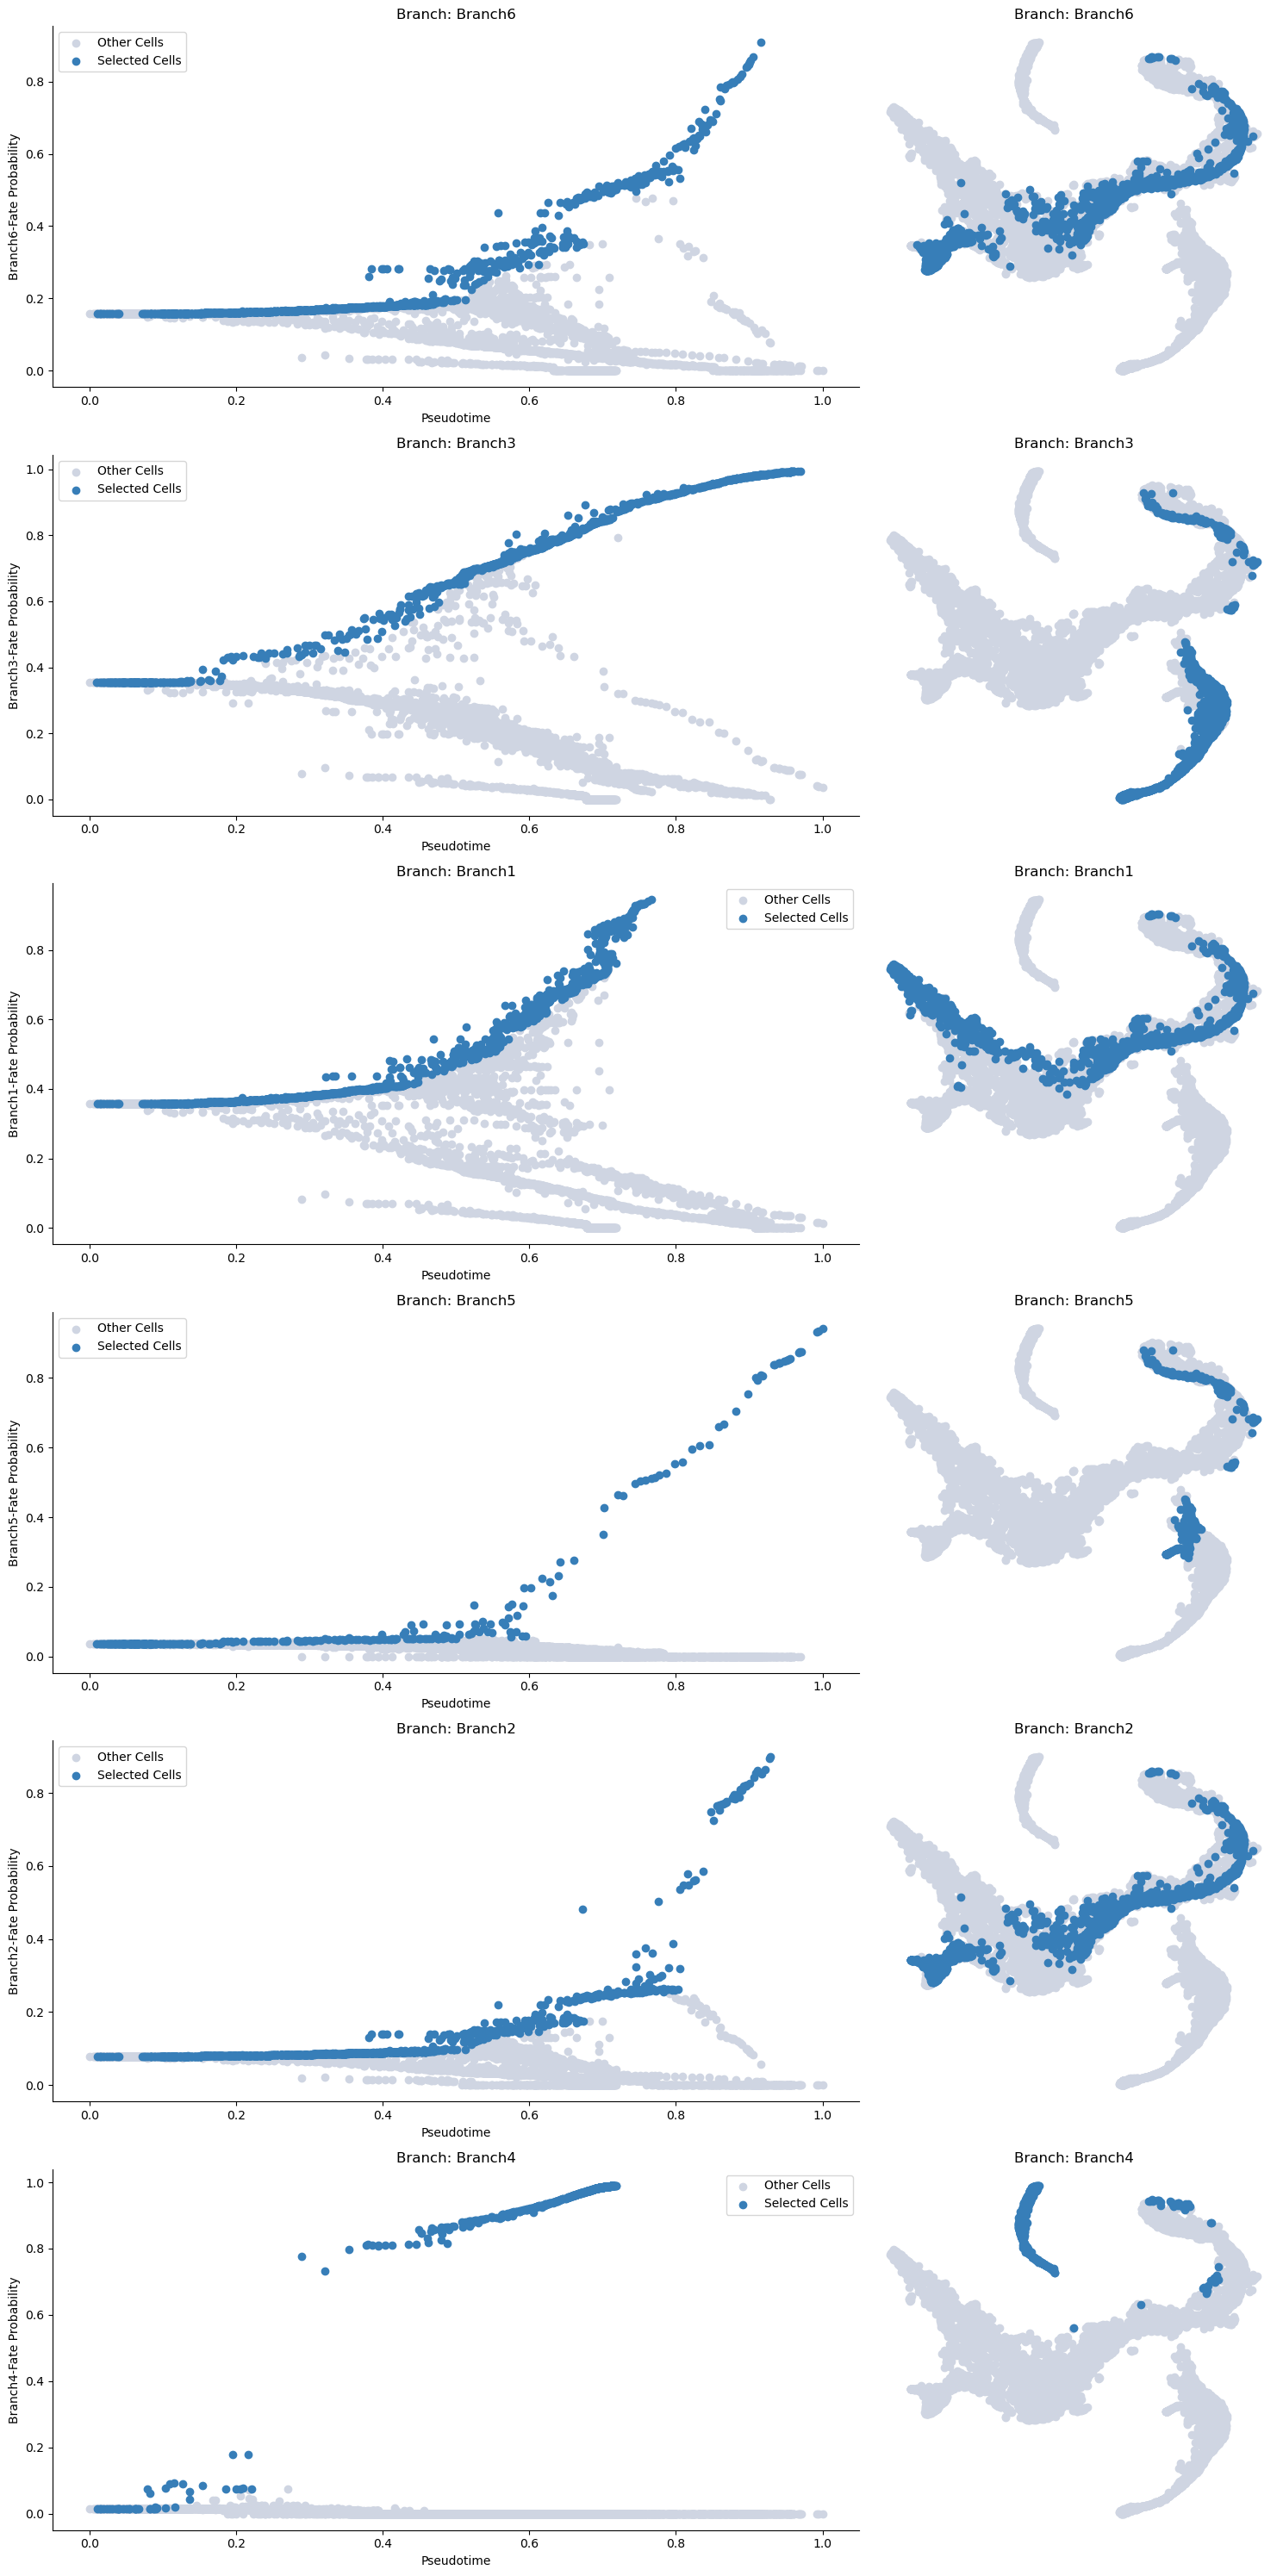

In [137]:
palantir.plot.plot_branch_selection(adata_bm, embedding_basis="tsne")
plt.show()

Now we can compute the gene expression trend along the trajectory. It is recommended that you MAGIC impute the data for this otherwise the trends will not be informative (due to 0s).

In [138]:
from sklearn.neighbors import NearestNeighbors
from scipy import sparse
from scipy.sparse import coo_matrix, csr_matrix


def run_MAGIC(
    adata,
    t=3,
    neighbors_key="neighbors",
    knn=30,
    use_rep=None,
    layer=None,
    n_components=30,
    metric="euclidean",
    impute=True,
    key_added="custom_magic",
):
    """

    Data denoising using MAGIC

    adata: Anndata object
    t: Number of steps to power the transition matrix (default = 3)

    neighbors_key: If nearest neighbor is already computed, supply the key (default = 'neighbors')

    knn: Number of nearest neighbors (default = 30)

    use_rep: Entry in adata to use if nearest neighbor is to be recomputed (default = None)

    layer: If to denoise specific layer as opposed to adata.X (default = None)

    n_components: Number of eigenvectors(values) of the transition matrix

    metric: Metric if nearest neighbor is to be computed (default = Euclidean)

    impute: Boolean to impute or not (default = True); if set to False will only compute diffusion maps

    key_added: key to store MAGIC imputed data
    """

    # number of cells
    N = adata.shape[0]

    # distance matrix
    if use_rep:
        print("Computing nearest neighbor graph")
        nbrs = NearestNeighbors(n_neighbors=int(knn), metric=metric).fit(
            adata.obsm[use_rep]
        )
        sparse_distance_matrix = nbrs.kneighbors_graph(
            adata.obsm[use_rep], mode="distance"
        )
    else:
        print("Using pre-computed nearest neighbor graph")
        if neighbors_key != "neighbors":
            sparse_distance_matrix = adata.obsp[neighbors_key + "_distances"]
        else:
            sparse_distance_matrix = adata.obsp["distances"]
        knn = adata.uns[neighbors_key]["params"]["n_neighbors"]
        print("Found pre-computed distance matrix with parameters: knn = " + str(knn))

    # find the nearest neighbor index to compute the distance to (ka in the description above)
    ka_val = int(np.ceil(knn / 3))
    print("Using knn_affinity = " + str(ka_val))

    # find the row, column indexes and distances from the distance matrix
    row, col, val = sparse.find(sparse_distance_matrix)

    # find the distance to rescale (this is the sigma parameter in the description above)
    ka_list = np.asarray([np.sort(val[row == j])[ka_val] for j in np.unique(row)])

    # rescale the distance matrix
    scaled_distance_matrix = sparse.csr_matrix(
        sparse_distance_matrix / ka_list[:, None]
    )

    # convert to affinity matrix
    x, y, scaled_dists = sparse.find(scaled_distance_matrix)
    print("Creating Kernel")
    W = sparse.csr_matrix((np.exp(-scaled_dists), (x, y)), shape=[N, N])

    # Ensure that the affinity between each cell to itself is the highest (= 1)
    W.setdiag(1)

    # Symmetrize
    kernel = W + W.T

    print("Creating Markov Matrix")
    # Markov
    D = np.ravel(kernel.sum(axis=1))
    D[D != 0] = 1 / D[D != 0]
    T = sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)

    # Eigen value dcomposition
    D, V = sparse.linalg.eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Alternatively:
    # For large data sets you can run MAGIC as follows as well:
    # The following code simply avoids constructing a dense Markov matrix
    if impute:
        print("Imputing")
        if layer:
            imputed_data_temp = adata.layers[layer].copy()
        else:
            imputed_data_temp = adata.X.copy()

        for steps in range(t):
            imputed_data_temp = T * imputed_data_temp

        adata.layers[key_added + "_imputed_data"] = imputed_data_temp
    else:
        print("Diffusion maps computed, impute set to False")
    # Create are results dictionary
    res = {"Markov_matrix": T, "EigenVectors": V, "EigenValues": D, "kernel": kernel}
    adata.uns[key_added + "_diffmap_results"] = res

    return adata

In [139]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

In [140]:
run_MAGIC(
    adata_bm,
    t=3,
    use_rep="X_pca",
    n_components=30,
    metric="euclidean",
    key_added="magic",
    impute=True,
)

Computing nearest neighbor graph
Using knn_affinity = 10
Creating Kernel
Creating Markov Matrix
Imputing


AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

In [141]:
gene_trends = palantir.presults.compute_gene_trends(
    adata_bm, expression_key="magic_imputed_data"
)

Branch1
[2025-04-18 13:10:54,312] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,322) and rank = 1.0.
[2025-04-18 13:10:54,313] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-04-18 13:10:54,338] [INFO    ] Sigma interpreted as element-wise standard deviation.
Branch2
[2025-04-18 13:10:54,799] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,167) and rank = 1.0.
[2025-04-18 13:10:54,800] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-04-18 13:10:54,817] [INFO    ] Sigma interpreted as element-wise standard deviation.
Branch3
[2025-04-18 13:10:55,155] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,072) and rank = 1.0.
[2025-04-18 13:10:55,155] [INFO    ] Using covariance function Matern52(ls=1.0).
[2025-04-18 13:10:55,173] [INFO    ] Sigma interpreted as element-wise standard deviation.
Branch4
[2025-04-18 13:10:55,482] [INFO    ] Using sparse Gaussian Process sinc

In [142]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Branch1', 'gene_trends_Branch2', 'gene_trends_Branch3', 'gene_trends_Branch4', 'gene_trends_Branch5', 'gene_trends_Branch6'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

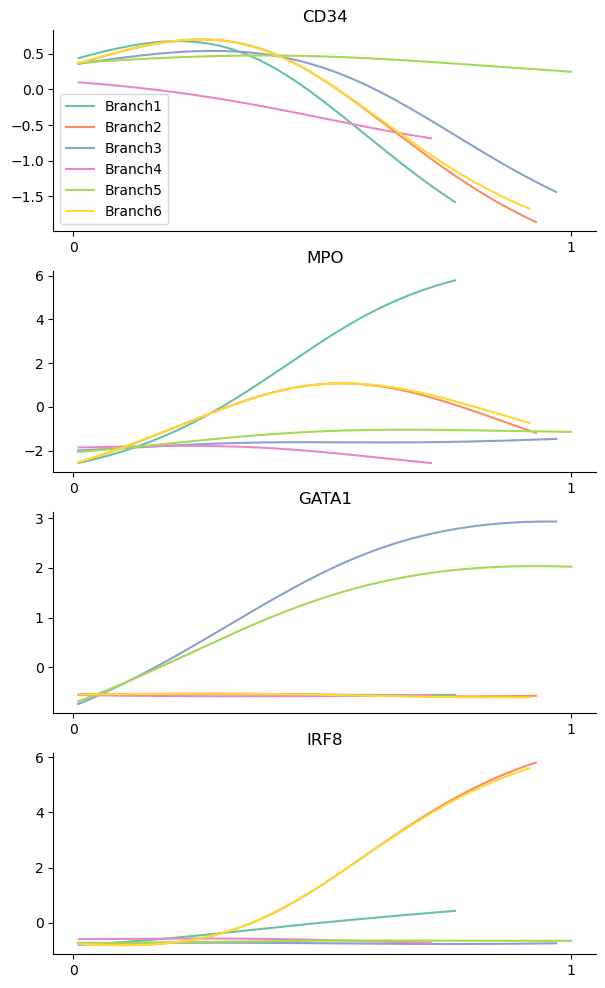

In [143]:
genes = ["CD34", "MPO", "GATA1", "IRF8"]
palantir.plot.plot_gene_trends(adata_bm, genes)
plt.show()

As heatmaps:

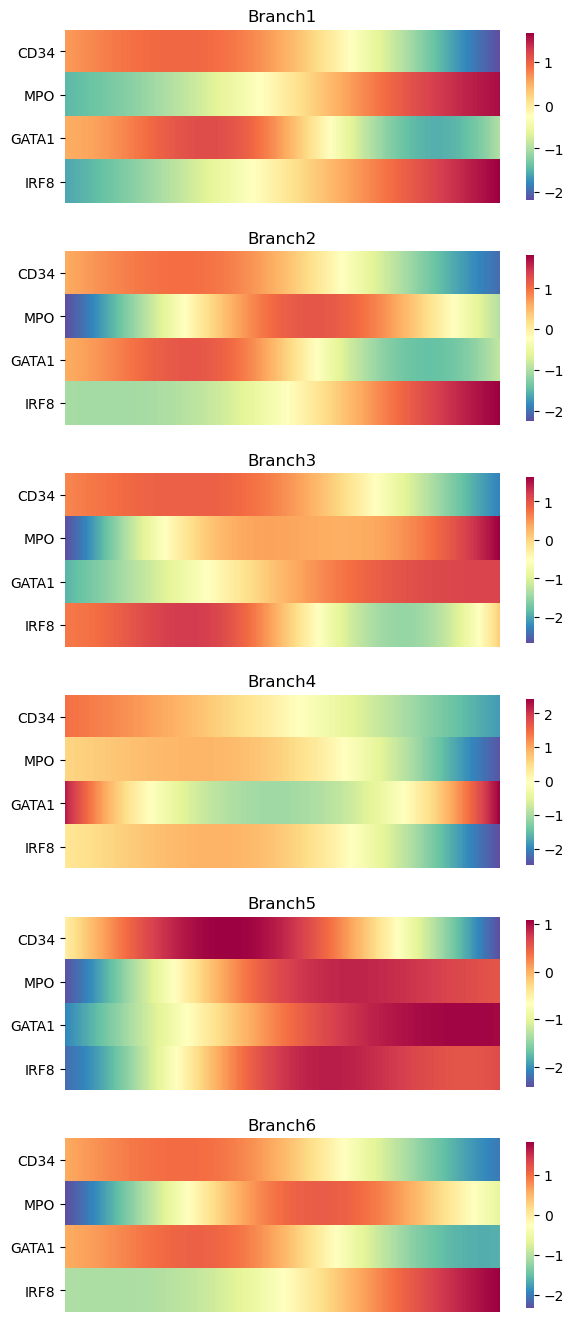

In [144]:
palantir.plot.plot_gene_trend_heatmaps(adata_bm, genes)
plt.show()

### Clustering gene expression trends

It may also be informative to group genes together based on how they trend along the pseudotime. For exposition, we will randomly sample 1000 genes from the data and cluster them based on how they trend along Branch1.

In [145]:
import random

sample_genes = list(random.sample(list(adata_bm.var_names), 1000))

In [146]:
help(palantir.presults.cluster_gene_trends)

Help on function cluster_gene_trends in module palantir.presults:

cluster_gene_trends(data: Union[anndata._core.anndata.AnnData, pandas.core.frame.DataFrame], branch_name: str, genes: Optional[List[str]] = None, gene_trend_key: Optional[str] = 'gene_trends', n_neighbors: int = 150, **kwargs) -> pandas.core.series.Series
    Cluster gene trends using the Leiden algorithm.
    
    This function applies the Leiden clustering algorithm to gene expression trends
    along the pseudotemporal trajectory. If the input is an AnnData object, it uses
    the gene trends stored in the `varm` attribute accessed using the `gene_trend_key`.
    If the input is a DataFrame, it directly uses the input data for clustering.
    
    Parameters
    ----------
    data : Union[AnnData, pd.DataFrame]
        AnnData object or a DataFrame of gene expression trends.
    branch_name : str
        Name of the branch for which the gene trends are to be clustered.
    genes : list of str, optional
        List 

In [147]:
communities = palantir.presults.cluster_gene_trends(
    adata_bm, branch_name="Branch1", genes=sample_genes
)

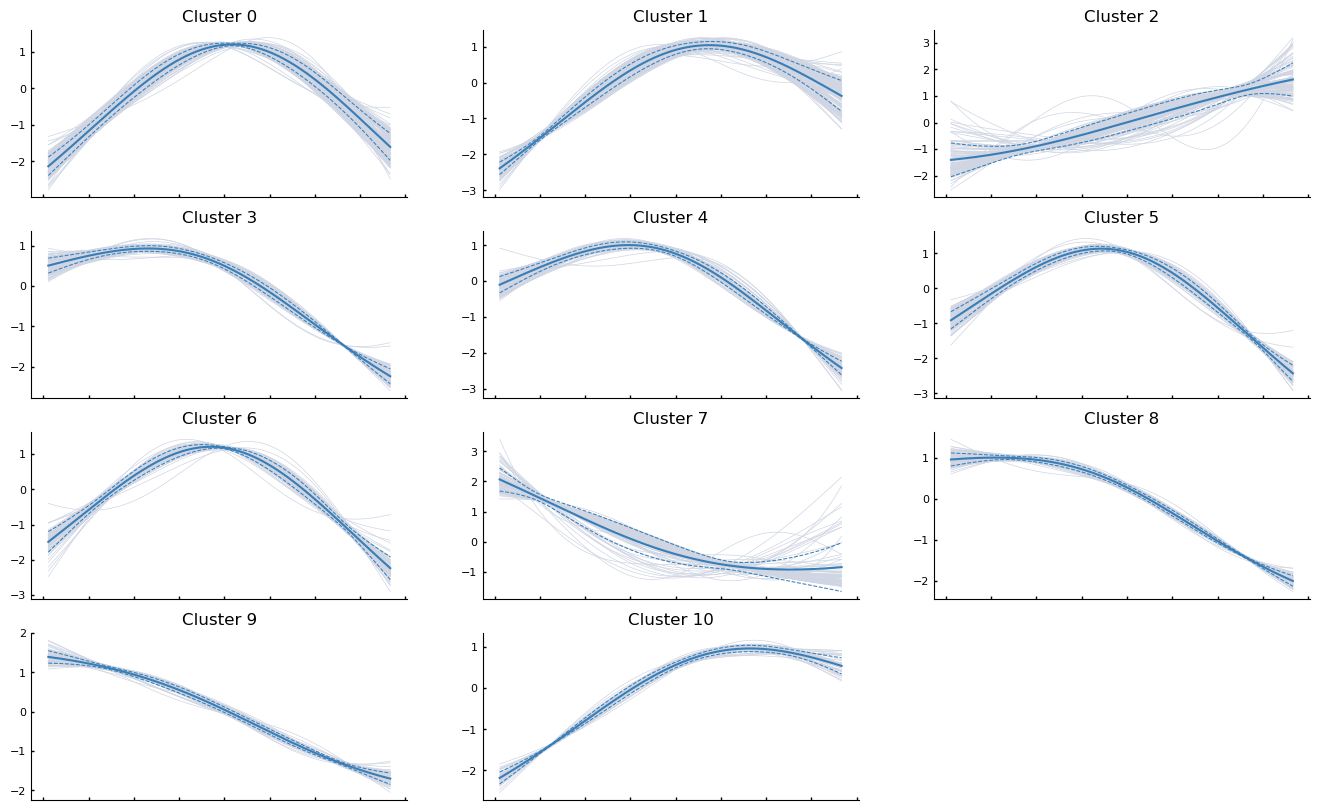

In [148]:
palantir.plot.plot_gene_trend_clusters(adata_bm, "Branch1")
plt.show()

## PAGA

PAGA (PArtition-based Graph Abstraction) is another method that can be used to study connectivities in single-cell data. Often, studying cell differentiation process using pseudotime may not be optimal due to issues resulting from inadequate sampling of cells. In such cases, the notion of connecting clusters of cells using graph-based metrics (to avoid errors that Euclidean distance might cause) has been proposed as an alternative, and PAGA is one such method. PAGA attempts to preserve both continuous and disconnected structure in the data. 

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6425583/

PAGA relies on both clustering and nearest neighbor graphs (which can be constructed on PCA or on diffusion components). We will provide code to do both.

In [149]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    var: 'gene_trends_clusters'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Branch1', 'gene_trends_Branch2', 'gene_trends_Branch3', 'gene_trends_Branch4', 'gene_trends_Branch5', 'gene_trends_Branch6'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

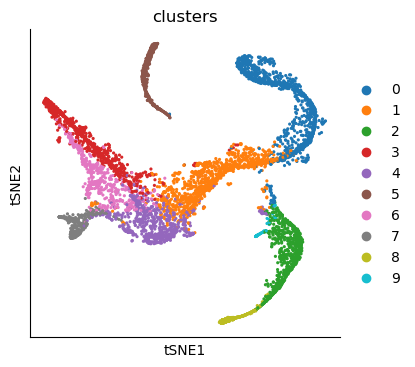

In [150]:
sc.pl.tsne(adata_bm, color="clusters")

In [151]:
# We are computing 300 principal components as that is what the authors used.
# The rationale was that they wanted to consider enough PCs to explain 75% of the variance in the data
sc.tl.pca(adata_bm, n_comps=300)

In [152]:
# Compute nearest neighbors
sc.pp.neighbors(
    adata_bm,
    n_neighbors=30,
    use_rep="X_pca",
    metric="euclidean",
    key_added="neighbors_30",
)

### PAGA with distances computed on PCA

Since we have already computed k-nearest neighbor distance graph on the PCA, we can simply invoke that result.

In [153]:
sc.tl.paga(adata_bm, groups="clusters", neighbors_key="neighbors_30")

In [154]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    var: 'gene_trends_clusters'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results', 'paga', 'clusters_sizes'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Branch1', 'gene_trends_Branch2', 'gene_trends_Branch3', 'gene_trends_Branch4', 'gene_trends_Branch5', 'gene_trends_Branch6'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

In [155]:
adata_bm.uns["paga"]

{'connectivities': <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 74 stored elements and shape (10, 10)>,
 'connectivities_tree': <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 9 stored elements and shape (10, 10)>,
 'groups': 'clusters'}

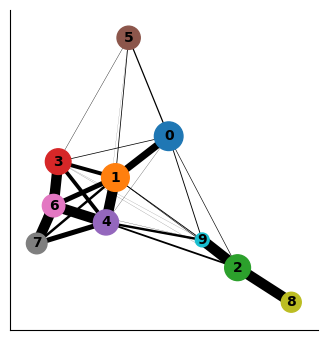

In [156]:
sc.pl.paga(adata_bm, color=["clusters"], node_size_scale=2)

Interpreting the plot above:
1. Each circle indicates a cluster and the size of the circle is proportional to size of the cluster.
2. Two circles that are phenotypically close to each other - as quantified by the distances computed on the PCA space - are connected to each other. 
3. The width of the connecting edges is proportional to the similarity between the clusters.


We can also highlight the expression of select genes onto the PAGA plot as follows:

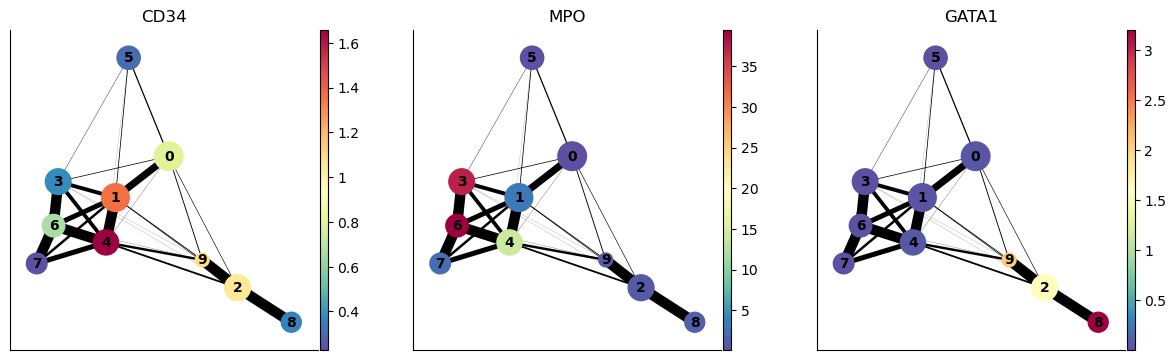

In [157]:
sc.pl.paga(adata_bm, color=["CD34", "MPO", "GATA1"], node_size_scale=2)

### PAGA on diffusion components

As we discussed above, PAGA can also compute connectivites between clusters based on distances in the diffusion space. For the example, below we will consider distances in the diffusion space defined by the first seven eigenvectors (ignoring the 0th eigenvector -- automatically ignored by PAGA).

In [158]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    var: 'gene_trends_clusters'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results', 'paga', 'clusters_sizes'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks'
    varm: 'PCs', 'gene_trends_Branch1', 'gene_trends_Branch2', 'gene_trends_Branch3', 'gene_trends_Branch4', 'gene_trends_Branch5', 'gene_trends_Branch6'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity'

In [159]:
sc.tl.diffmap(adata_bm, n_comps=30, neighbors_key="neighbors_30")

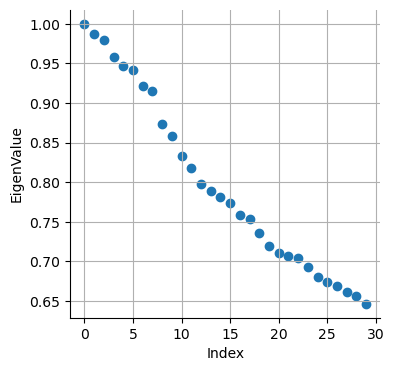

In [160]:
plt.scatter(range(len(adata_bm.uns["diffmap_evals"])), adata_bm.uns["diffmap_evals"])
plt.xlabel("Index")
plt.ylabel("EigenValue")
plt.grid("on")

Based on the above plot, we will consider only the top 7 components:

In [161]:
adata_bm.obsm["diffmap_evecs"] = adata_bm.obsm["X_diffmap"][:, 1:8]
adata_bm.uns["diffmap_evals"] = adata_bm.uns["diffmap_evals"][1:8]

In [162]:
adata_bm.obsm["diffmap_evecs"].shape

(5780, 7)

Compute neighbors in diffusion components space:

In [163]:
sc.pp.neighbors(
    adata_bm, n_neighbors=30, use_rep="diffmap_evecs", key_added="diff_neighbors"
)

Re-do PAGA on diffusion map space:

In [164]:
sc.tl.paga(adata_bm, groups="clusters", neighbors_key="diff_neighbors")

In [165]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    var: 'gene_trends_clusters'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results', 'paga', 'clusters_sizes', 'diff_neighbors'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks', 'diffmap_evecs'
    varm: 'PCs', 'gene_trends_Branch1', 'gene_trends_Branch2', 'gene_trends_Branch3', 'gene_trends_Branch4', 'gene_trends_Branch5', 'gene_trends_Branch6'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity', 'diff_neighbors_distances', 'diff_neighbors_connectivities'

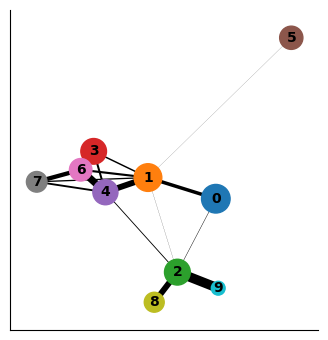

In [166]:
sc.pl.paga(adata_bm, node_size_scale=2)

As you can see the two results of PAGA look visually quite similar (except that cluster 9 was more connected to other clusters when computing distances in the PCA space vs when computing in the diffusion space). It will be up to you to evaluate such cases using what is known about the cell types. In this case, Cluster 9 is ITGA2B+ (Megakaryocytes) and it is more phenotypically closer to cluster 2 and 8 as opposed to clusters 1 and 4. Therefore, diffusion distance based PAGA would be more faithful representation of the data here. 

## Using results to quantify distance between clusters

You can extract the similarity between clusters using diffusion maps space as follows. We see 0 when two clusters are not connected to each other in PAGA.

In [167]:
df = pd.DataFrame(
    adata_bm.uns["paga"]["connectivities"].toarray(),
    index=["Cluster-" + str(j) for j in np.unique(adata_bm.obs["clusters"])],
    columns=["Cluster-" + str(j) for j in np.unique(adata_bm.obs["clusters"])],
)

df

Cluster-0  Cluster-1  Cluster-2  Cluster-3  Cluster-4  Cluster-5  \
Cluster-0   0.000000   0.335836   0.042759   0.008247   0.004014   0.008583   
Cluster-1   0.335836   0.000000   0.014329   0.140419   0.569843   0.011620   
Cluster-2   0.042759   0.014329   0.000000   0.000000   0.083675   0.000000   
Cluster-3   0.008247   0.140419   0.000000   0.000000   0.193001   0.006204   
Cluster-4   0.004014   0.569843   0.083675   0.193001   0.000000   0.001533   
Cluster-5   0.008583   0.011620   0.000000   0.006204   0.001533   0.000000   
Cluster-6   0.000415   0.204404   0.000626   0.940574   0.677937   0.000000   
Cluster-7   0.000000   0.125988   0.000000   0.005905   0.178738   0.000000   
Cluster-8   0.000000   0.000000   0.564495   0.000000   0.000000   0.000000   
Cluster-9   0.001461   0.003320   0.917967   0.000000   0.007358   0.000000   

           Cluster-6  Cluster-7  Cluster-8  Cluster-9  
Cluster-0   0.000415   0.000000   0.000000   0.001461  
Cluster-1   0.204404   0.125988   0.000000   0.003320  
Cluster-2   0.000626   0.000000   0.564495   0.917967  
Cluster-3   0.940574   0.005905   0.000000   0.000000  
Cluster-4   0.677937   0.178738   0.000000   0.007358  
Cluster-5   0.000000   0.000000   0.000000   0.000000  
Cluster-6   0.000000   0.411622   0.000000   0.000000  
Cluster-7   0.411622   0.000000   0.000000   0.000000  
Cluster-8   0.000000   0.000000   0.000000   0.000000  
Cluster-9   0.000000   0.000000   0.000000   0.000000

Note: We can always repurpose this code to define distance or similarity between any two groups of cells by just replacing `clusters` column in obs with whatever grouping of cells we want.

Alternatively, for data where cells are along a continuum, we can use the diffusion components to compute phenotypic distances between cells or clusters. As we discussed, Euclidean distance in the diffusion component space is a good approximation for phenotypic distance between cells. Of course, we need to be careful with only the meaningful diffusion components (e.g. in the above case we will use diffusion components 1-7). 

In the following code, we will compute distance (A) between each pair of cells within cluster 0 (B) between cells in cluster 0 and cluster 1. 

In [168]:
adata_bm

AnnData object with n_obs × n_vars = 5780 × 14651
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'palantir_entropy'
    var: 'gene_trends_clusters'
    uns: 'cluster_colors', 'ct_colors', 'palantir_branch_probs_cell_types', 'clusters_colors', 'pca', 'neighbors_30', 'diffmap_evals', 'DM_EigenValues', 'palantir_waypoints', 'magic_diffmap_results', 'paga', 'clusters_sizes', 'diff_neighbors'
    obsm: 'tsne', 'MAGIC_imputed_data', 'palantir_branch_probs', 'X_tsne', 'X_pca', 'X_diffmap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'palantir_fate_probabilities', 'branch_masks', 'diffmap_evecs'
    varm: 'PCs', 'gene_trends_Branch1', 'gene_trends_Branch2', 'gene_trends_Branch3', 'gene_trends_Branch4', 'gene_trends_Branch5', 'gene_trends_Branch6'
    layers: 'magic_imputed_data'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'DM_Kernel', 'DM_Similarity', 'diff_neighbors_distances', 'diff_neighbors_connectivities'

In [169]:
adata_bm.obsm["diffmap_evecs"].shape

(5780, 7)

In [170]:
cells_C0 = np.where(adata_bm.obs["clusters"] == "0")[0]
cells_C1 = np.where(adata_bm.obs["clusters"] == "1")[0]

In [171]:
print(len(cells_C0), len(cells_C1))

1118 984


In [172]:
from sklearn.metrics import pairwise_distances

distance_pairwise_C0 = pairwise_distances(adata_bm.obsm["diffmap_evecs"][cells_C0, :])
distance_pairwise_C0_C1 = pairwise_distances(
    adata_bm.obsm["diffmap_evecs"][cells_C0, :],
    adata_bm.obsm["diffmap_evecs"][cells_C1, :],
)

In [173]:
print(distance_pairwise_C0.shape, distance_pairwise_C0_C1.shape)

(1118, 1118) (1118, 984)


As we see, `distance_pairwise_C0` holds the pairwise distance between cells in cluster 0; `distance_pairwise_C0_C1` holds the pairwise distance between cells in cluster 0 and cluster 1.

We can visualize the distances as a boxplot for comparison. Also, note that `distance_pairwise_C0` is a symmetric matrix as distance from cell1 in cluster 0 to cell2 in cluster 0 is the same as distance from cell2 in cluster0 to cell1 in cluster 0. So we will only look at the upper traingle of the `distance_pairwise_C0` matrix.

In [174]:
within_C0 = distance_pairwise_C0[np.triu_indices(distance_pairwise_C0.shape[0], k=1)]
between_C0_C1 = distance_pairwise_C0_C1.flatten()

Text(0, 0.5, 'Distance in diffusion space')

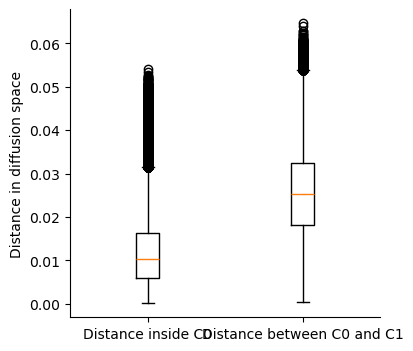

In [175]:
plt.boxplot([within_C0, between_C0_C1])
plt.xticks([1, 2], ["Distance inside C0", "Distance between C0 and C1"])
plt.ylabel("Distance in diffusion space")